# DETECÇÃO DE FRAUDES EM TRANSAÇÕES FINANCEIRAS

# Objetivo Principal do Projeto

Queremos encontrar o ponto de threshold ideal para o modelo já treinado apresentado à parte (`score_fraude_modelo`, onde 0 é o risco mais baixo e 100 o mais alto). Precisamos definir o ponto de corte que maximize os lucros da empresa, de forma que todos os pagamentos com menor Score sejam aprovados e os maiores sejam rejeitados.

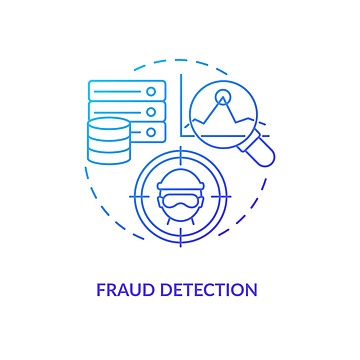

# Entendendo um pouco mais sobre fraudes em transações financeiras

## Importância da Identificação de Fraudes
A identificação de transações fraudulentas é uma preocupação central para instituições financeiras em todo o mundo. Fraudes financeiras podem resultar em perdas significativas, afetando a lucratividade e a confiança dos clientes na instituição. A fraude ocorre quando transações são realizadas de forma ilegal ou sem a autorização adequada, e identificar esses casos é crucial para proteger tanto os ativos financeiros da empresa quanto os de seus clientes.

## Impactos Financeiros
As transações fraudulentas têm um impacto financeiro direto e devastador. Para este projeto específico, a instituição financeira ganha 10% do valor de cada pagamento aprovado corretamente. No entanto, cada fraude aprovada resulta na perda de 100% do valor do pagamento. Isso significa que, para cada transação fraudulenta, a empresa não apenas deixa de ganhar a comissão de 10%, mas também perde todo o valor transacionado. Essa dinâmica ressalta a importância de uma identificação eficaz das fraudes, pois mesmo um pequeno número de fraudes pode rapidamente anular os lucros obtidos por muitas transações legítimas.

## Exemplificação dos Impactos
Para ilustrar, considere o seguinte cenário: se uma empresa aprova 100 transações legítimas de 1.000 reais cada, ela ganha 10.000 reais (10% de 1.000 * 100). No entanto, se uma única transação fraudulenta de 1.000 reais for aprovada, a perda é desse mesmo valor, anulando o ganho de 10 transações legítimas. Portanto, a identificação e prevenção de fraudes são fundamentais para manter a saúde financeira da instituição.



# Principais KPIs do Projeto

## KPIs de Eficiência e Eficácia do Modelo

### Taxa de Detecção de Fraudes (Precision)
- Descrição: Percentual de transações identificadas como fraudulentas que realmente são fraudes.
- Fórmula: (Número de Fraudes Corretamente Identificadas / Número Total de Transações Identificadas como Fraudes) * 100%

### Taxa de Cobertura de Fraudes (Recall)
- Descrição: Percentual de transações fraudulentas identificadas corretamente pelo sistema em relação ao total de fraudes.
- Fórmula: (Número de Fraudes Corretamente Identificadas / Número Total de Fraudes) * 100

### Acurácia do Modelo
- Descrição: Percentual de todas as transações (fraudulentas e não fraudulentas) que foram classificadas corretamente.
- Fórmula: (Número de Transações Corretamente Classificadas / Número Total de Transações) * 100

### Taxa de Falsos Positivos
- Descrição: Percentual de transações não fraudulentas que foram incorretamente classificadas como fraudes.
- Fórmula: (Número de Falsos Positivos / Número Total de Transações Não Fraudulentas) * 100

### Taxa de Falsos Negativos
- Descrição: Percentual de transações fraudulentas que não foram detectadas pelo sistema.
- Fórmula: (Número de Falsos Negativos / Número Total de Transações Fraudulentas) * 100


## KPIs Financeiros

### Valor Total de Fraudes Prevenidas
- Descrição: Quantidade de dinheiro que foi salva ao identificar e bloquear transações fraudulentas.
- Fórmula: Soma do valor de todas as transações fraudulentas bloqueadas

### Custo de Fraudes Não Detectadas
- Descrição: Quantidade de dinheiro perdida devido a fraudes que não foram identificadas e bloqueadas.
- Fórmula: Soma do valor de todas as transações fraudulentas que passaram pelo sistema

### Taxa de Fraude (Fraud Rate)
- Descrição: Percentual de transações que são fraudulentas em relação ao total de transações processadas.
- Fórmula: (Número Total de Transações Fraudulentas / Número Total de Transações) * 100

# Import das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, log_loss, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency, ks_2samp, mannwhitneyu
from xgboost import XGBClassifier
import lightgbm as lgb
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import mlflow
import mlflow.lightgbm
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

# Dicionário de dados

- score_1 a score_10: são notas de bureau de crédito que a empresa adquiriu para identificar se o comprador é confiável ou outros dados anonimizados que não temos informação sobre
- pais: país de compra
- produto: produto que está sendo comprado no e-commerce
- categoria_produto: categoria a qual esse produto se encaixa
- entrega_doc_1 a entrega_doc_3: documentos requisitados no momento de fazer a conta. 0 = N = nao entregou. Y = 1 = entregou. Se vazio, considere que não entregou
- data_compra: data e hora exata da compra registrada
- valor_compra: valor da compra registrada
- score_fraude_modelo: score dado pelo modelo atual. É a probabilidade daquela compra ser uma fraude ou não. Quanto mais próximo de 100, maior a certeza do modelo que é fraude
- fraude: informação se aquela compra era fraudulenta ou não. Foi inserida após alguns dias, para termos o feedback real se de fato era fraudulenta ou não. 0 se não era fraudulenta e 1 se era fraudulenta

# Análise Exploratória dos Dados



In [2]:
# Carregando os dados e conhecendo as features
df = pd.read_csv("../data/raw/dados.csv")
df.head()

,score_1,score_2,score_3,score_4,score_5,score_6,pais,score_7,produto,categoria_produto,score_8,score_9,score_10,entrega_doc_1,entrega_doc_2,entrega_doc_3,data_compra,valor_compra,score_fraude_modelo,fraude
0,4,0.7685,94436.24,20.0,0.444828,1.0,BR,5,Máquininha Corta Barba Cabelo Peito Perna Pelo...,cat_8d714cd,0.883598,240.0,102.0,1,NaN,N,2020-03-27 11:51:16,5.64,66,0
1,4,0.7550,9258.50,1.0,0.000000,33.0,BR,0,Avental Descartavel Manga Longa - 50 Un. Tnt ...,cat_64b574b,0.376019,4008.0,0.0,1,Y,N,2020-04-15 19:58:08,124.71,72,0
2,4,0.7455,242549.09,3.0,0.000000,19.0,AR,23,Bicicleta Mountain Fire Bird Rodado 29 Alumini...,cat_e9110c5,0.516368,1779.0,77.0,1,NaN,N,2020-03-25 18:13:38,339.32,95,0
3,4,0.7631,18923.90,50.0,0.482385,18.0,BR,23,Caneta Delineador Carimbo Olho Gatinho Longo 2...,cat_d06e653,0.154036,1704.0,1147.0,1,NaN,Y,2020-04-16 16:03:10,3.54,2,0
4,2,0.7315,5728.68,15.0,0.000000,1.0,BR,2,Resident Evil Operation Raccoon City Ps3,cat_6c4cfdc,0.855798,1025.0,150.0,1,NaN,N,2020-04-02 10:24:45,3.53,76,0


In [3]:
# Conhecendo a estrutura do DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   score_1              150000 non-null  int64  
 1   score_2              137016 non-null  float64
 2   score_3              137016 non-null  float64
 3   score_4              149635 non-null  float64
 4   score_5              150000 non-null  float64
 5   score_6              149989 non-null  float64
 6   pais                 149806 non-null  object 
 7   score_7              150000 non-null  int64  
 8   produto              150000 non-null  object 
 9   categoria_produto    150000 non-null  object 
 10  score_8              150000 non-null  float64
 11  score_9              149989 non-null  float64
 12  score_10             149635 non-null  float64
 13  entrega_doc_1        150000 non-null  int64  
 14  entrega_doc_2        41143 non-null   object 
 15  entrega_doc_3    

É nítido que algumas colunas tem diversos registros nulos ou NaN, que precisarão ser tratados ou não, dependendo da estratégia seguida mais pra frente. A coluna que mais chama atenção no momento é a `entrega_doc_2`, que tem menos de 30% dos registros preenchidos.

Como nesse caso temos especificado no Dicionário de Dados que um registro vazio é a mesma coisa que "N" (não entregou), depois podemos preencher essas linhas com esse valor. Logicamente essa coluna será bem desbalanceada, pois a grande maioria não vai ter entregado o documento.

Outras coisas que me chamaram a atenção foram: tanto a coluna `entrega_doc_2` quanto a `entrega_doc_3` estão classificadas como objetos, por terem os valores Y e N para representar se entregou ou não cada documento. Podemos transformá-las em categorias numéricas, seguindo o padrão da coluna `entrega_doc_1`, pois se formos usar no modelo, elas não poderão ser categóricas. E por último, a coluna `data_compra` está classificada como objeto, e precisaria ser transformada em data pra não termos nenhum problema.

In [4]:
# Visualizando a quantidade de valores únicos por coluna
df.nunique()

score_1                     4
score_2                  7672
score_3                135090
score_4                    51
score_5                 43207
score_6                  1338
pais                       51
score_7                    59
produto                127804
categoria_produto        8324
score_8                149999
score_9                  7297
score_10                 1793
entrega_doc_1               2
entrega_doc_2               2
entrega_doc_3               2
data_compra            145813
valor_compra            17831
score_fraude_modelo       101
fraude                      2
dtype: int64

Analisando os valores únicos por colunas, o que mais me preocupa é a alta cardinalidade da coluna `produto`. São mais de 127 mil produtos diferentes para 150 mil registros. É impossível que o modelo consiga encontrar padrões bem definidos nessa distribuição, e assim não conseguirá ser generalista para novos dados.

Muitos valores distintos em variáveis numéricas não é algo tão problemático pois poderemos criar ranges para facilitar a identificação de padrões se for necessário. E no caso da coluna `data_compra`, sei que quase todos os valores são diferentes pois eles tem o registro de horário junto à data, o que pode ser facilmente resolvido através de feature engineering, o que não vai ser o caso para esse projeto, pois análises temporais podem degradar o modelo com o tempo. Então na parte de pré-processamento eu seguirei com a exclusão dessa coluna.

Apesar de já ter visto quantos valores não nulos cada coluna tem, eu quero verificar em valores percentuais a quantidade de nulos pra cada uma, tendo uma visão mais clara das variáveis mais afetadas.

In [5]:
# Percentual de valores nulos por coluna
(df.isnull().sum() / df.shape[0] * 100).round(2).sort_values(ascending=False)

entrega_doc_2          72.57
score_2                 8.66
score_3                 8.66
score_4                 0.24
score_10                0.24
pais                    0.13
score_9                 0.01
score_6                 0.01
score_1                 0.00
produto                 0.00
score_7                 0.00
score_5                 0.00
score_8                 0.00
categoria_produto       0.00
entrega_doc_1           0.00
entrega_doc_3           0.00
data_compra             0.00
valor_compra            0.00
score_fraude_modelo     0.00
fraude                  0.00
dtype: float64

E como já foi citado anteriormente, `entrega_doc_2` tem a grande maioria dos seus registros nulos, mas o restante das features não tem percentuais preocupantes nesse quesito.

# Análise Exploratória Univariada

Após ter uma ideia geral dos dados com que estamos lidando, vamos iniciar a análise univariada, selecionando primeiro as colunas de dados categóricos, e depois de dados numéricos.

## Variáveis Categóricas

Como analisado anteriormente, a coluna `score_1` só tem 4 valores únicos (números de 1 a 4), e por isso vou considerar que é uma variável categórica.

Vamos analisar a distribuição dos valores nessa coluna.

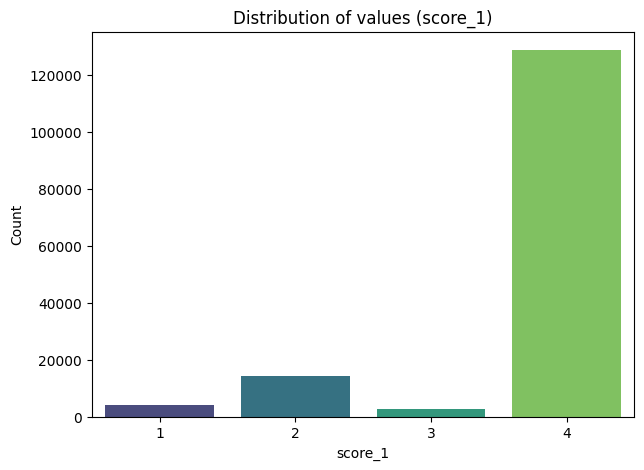

In [67]:
# Gráfico de distribuição dos valores de score_1
plt.figure(figsize=(7, 5))
sns.countplot(data=df, x='score_1', palette='viridis')
plt.title('Distribution of values (score_1)')
plt.xlabel('score_1')
plt.ylabel('Count')
plt.show()

Fica claro que a maioria das pessoas estão concentradas no valor 4, e logo em sequência no valor 2, podendo indicar se existe algum padrão referente à essa variável que aumente a possibilidade do registro ser uma transação fraudulenta.

Pra visualizar melhor isso, vamos visualizar a distribuição de fraudes classificadas por valor na coluna `score_1`.

In [7]:
# Total de fraudes no DataFrame
total_frauds = df[df['fraude'] == 1].shape[0]

# Percentual de fraudes para cada valor de score_1 em relação ao total de fraudes
(df[df['fraude'] == 1].groupby('score_1').size() / total_frauds * 100).round(2).sort_values(ascending=False)

score_1
4    76.39
2    14.91
1     5.27
3     3.44
dtype: float64

Como já era esperado, pela proporção da distribuição os valores 4 e 2 são os que mais somam registros de fraudes. Mas pela diferença de registros entre os 4 valores possíveis na coluna, os percentuais totais dos valores 1 e 3 também ficaram altos.

Por isso, vamos analisar quantos % dos registros totais de cada valor são fraudes, pra tentar encontrar um possível padrão de comportamento.

In [8]:
# Percentual de registros que são fraudes para cada valor da coluna
(df[df['fraude'] == 1].groupby('score_1').size() / df.groupby('score_1').size() * 100).round(2).sort_values(ascending=False)

score_1
1    9.42
3    9.06
2    7.78
4    4.46
dtype: float64

Perceba que interessante, apesar dos valores 1 e 3 serem menos significativos em total de registros no conjunto de dados, em percentual do total de registros de cada valor, são os que mais contém fraudes, podendo indicar um possível padrão nas transações fraudulentas.

Agora vamos analisar a coluna `pais`.

In [9]:
# Visualizando a quantidade de registros para cada país
df['pais'].value_counts()

pais
BR    111628
AR     31964
UY      2967
US      2273
SE       358
MX       236
RU        73
ES        69
CO        64
GB        43
FR        18
IT        14
PT        13
CL         9
DE         9
PE         5
PY         4
EC         4
AU         3
UA         3
CN         3
CA         3
BE         3
NZ         3
CH         3
PA         3
BO         2
LB         2
PR         2
NL         2
CR         2
AE         2
AD         1
GE         1
KR         1
IN         1
HN         1
NI         1
GR         1
DO         1
EG         1
TR         1
BS         1
PH         1
GH         1
TW         1
FI         1
NO         1
IL         1
JP         1
ZA         1
Name: count, dtype: int64

In [10]:
# Percentual de fraudes para cada valor de pais em relação ao total de fraudes
(df[df['fraude'] == 1].groupby('pais').size() / total_frauds * 100).round(2).sort_values(ascending=False)

pais
BR    82.16
AR    15.72
US     0.93
UY     0.39
SE     0.20
RU     0.08
ES     0.07
DE     0.04
FR     0.04
MX     0.04
EC     0.03
NL     0.03
CO     0.01
CL     0.01
KR     0.01
FI     0.01
PT     0.01
NZ     0.01
dtype: float64

In [11]:
# Percentual de registros que são fraudes para cada valor da coluna
(df[df['fraude'] == 1].groupby('pais').size() / df.groupby('pais').size() * 100).round(2).sort_values(ascending=False)

pais
FI    100.00
KR    100.00
NL    100.00
EC     50.00
NZ     33.33
DE     33.33
FR     16.67
CL     11.11
RU      8.22
PT      7.69
ES      7.25
BR      5.52
SE      4.19
AR      3.69
US      3.08
CO      1.56
MX      1.27
UY      0.98
AD       NaN
AE       NaN
AU       NaN
BE       NaN
BO       NaN
BS       NaN
CA       NaN
CH       NaN
CN       NaN
CR       NaN
DO       NaN
EG       NaN
GB       NaN
GE       NaN
GH       NaN
GR       NaN
HN       NaN
IL       NaN
IN       NaN
IT       NaN
JP       NaN
LB       NaN
NI       NaN
NO       NaN
PA       NaN
PE       NaN
PH       NaN
PR       NaN
PY       NaN
TR       NaN
TW       NaN
UA       NaN
ZA       NaN
dtype: float64

Com essas visualizações, fica claro que apesar de termos registros de 51 países, a nossa análise será focada no Brasil e Argentina. Motivos:
- mais de 95% dos registros do conjunto de dados são desses países;
- mais de 98% das transações fraudulentas registradas foram nesses países;
- alguns países tem pouquíssimos registros, alguns apenas 1, tornando impossível o nosso modelo generalizar bem através dessa feature (alguns países vão ter 100% dos seus registros como fraudes, mas isso não quer dizer que toda transação que venha a ocorrer será fraudulenta, e isso vale igualmente para países que não tem nenhuma fraude registrada).

Sabendo disso, será interessante treinar o modelo com uma cardinalidade menor, separando essa coluna em "Brasil", "Argentina" e "Outros", por exemplo.

As próximas variáveis serão `produto` e `categoria_produto`. A coluna de produto já mostrou ter uma alta cardinalidade, então preciso analisar se existe alguma possibilidade de tratamento que faça com que essa seja uma feature interessante para o treinamento do modelo, ou se ela será eliminada.

In [12]:
# Visualizando a quantidade de registros para cada produto
df['produto'].value_counts()

produto
Fone De Ouvido Sem Fio Xiaomi Airdots Preto                     83
Xiaomi Redmi Note 8 Dual Sim 64 Gb Azul-netuno 4 Gb Ram         51
Clean Sept - Álcool Em Gel 70% 500 Ml                           49
Tapete Ilustrativo Pista Carrinho Hot Wheels 0,60x1,20m         47
Máscara Descartável Tripla Com Elástico Proteção Anvisa 50un    47
                                                                ..
Escova Dental Curaprox 5460 Ultra Soft Com 3 Unidades            1
Gamepad Joystick Para Telefono Celular Android Bluetooth Cuo     1
Soldadora Inverter 180 A + Máscara + 2 Esc. Mag 4´ Kroner        1
Tripa Para Fazer Linguiça - 45 Metros Long Short                 1
Corpinho Avulso Joseph, Josepha Ou Placa Sem Sexo                1
Name: count, Length: 127804, dtype: int64

Somente essa visualização já nos diz muito, visto que o produto que mais tem registros aparece somente 83 vezes, e isso representa 0,05% do dataset. Ou seja, devido à alta cardinalidade irei excluir essa coluna na parte de pré-processamento.

In [13]:
# Visualizando a quantidade de registros para cada categoria de produto
df['categoria_produto'].value_counts()

categoria_produto
cat_43b9c10    2331
cat_d69bed9    1799
cat_604df77    1784
cat_6c4cfdc    1449
cat_4249bd8    1191
               ... 
cat_805739b       1
cat_9c506bd       1
cat_ef38976       1
cat_c029284       1
cat_07b5ae2       1
Name: count, Length: 8324, dtype: int64

In [14]:
# Conferindo novamente quantas categorias diferentes existem no dataset
df['categoria_produto'].nunique()

8324

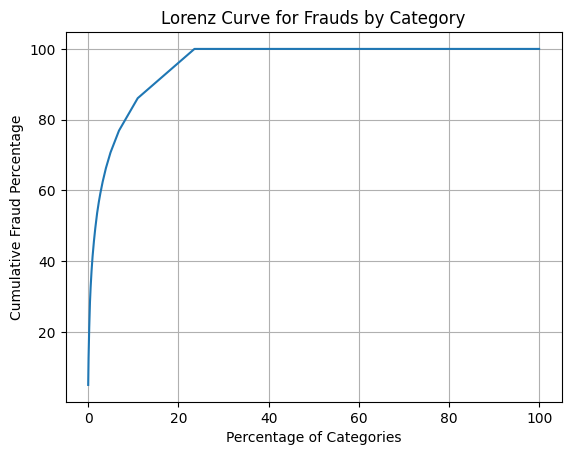

,categoria_produto,fraude,percent_cumsum_fraude,percent_cumsum_categoria
0,cat_43b9c10,380,5.066667,0.000000
1,cat_d9753d4,115,6.600000,0.012013
2,cat_4249bd8,98,7.906667,0.024027
3,cat_8ef7164,81,8.986667,0.036040
4,cat_6c4cfdc,74,9.973333,0.048054
...,...,...,...,...
8319,cat_da1353e,0,100.000000,99.939933
8320,cat_795e028,0,100.000000,99.951946
8321,cat_805739b,0,100.000000,99.963960
8322,cat_5dac1f2,0,100.000000,99.975973


50% das fraudes estão acumuladas em aproximadamente 1.62% das categorias
80% das fraudes estão acumuladas em aproximadamente 8.22% das categorias
85% das fraudes estão acumuladas em aproximadamente 10.46% das categorias


In [68]:
# Contagem de itens por categoria
item_per_category = df.categoria_produto.value_counts().reset_index().rename(columns={"index": "categoria_produto", 0: "counter"})

# Soma de fraudes por categoria
fraud_per_category = df.groupby(['categoria_produto']).fraude.sum().reset_index()

# Merge dos dataframes
df_item_fraud = pd.merge(item_per_category, fraud_per_category, on='categoria_produto', how="left")

# Ordenar pelo número de fraudes em ordem decrescente
df_item_fraud = df_item_fraud.sort_values(by='fraude', ascending=False).reset_index(drop=True)

# Cálculo da porcentagem cumulativa de fraudes
df_item_fraud['percent_cumsum_fraude'] = df_item_fraud['fraude'].cumsum() / df.fraude.sum() * 100

# Cálculo da porcentagem cumulativa de categorias
df_item_fraud['percent_cumsum_categoria'] = df_item_fraud.index / len(df_item_fraud) * 100

# Plot da curva de Lorenz
plt.plot(df_item_fraud['percent_cumsum_categoria'], df_item_fraud['percent_cumsum_fraude'])
plt.xlabel('Percentage of Categories')
plt.ylabel('Cumulative Fraud Percentage')
plt.title('Lorenz Curve for Frauds by Category')
plt.grid(True)
plt.show()

# Exibir a tabela com as porcentagens
display(df_item_fraud[['categoria_produto', 'fraude', 'percent_cumsum_fraude', 'percent_cumsum_categoria']])

# Encontrar os pontos exatos
acumulated_frauds = [50, 80, 85]  # Exemplo de pontos de interesse

for perc in acumulated_frauds:
    num_categorias = df_item_fraud[df_item_fraud['percent_cumsum_fraude'] <= perc]['percent_cumsum_categoria'].max()
    print(f"{perc}% das fraudes estão acumuladas em aproximadamente {num_categorias:.2f}% das categorias")

Com as análises acima, vimos que a cardinalidade da coluna `categoria_produto` é muito menor que a de produto, e que menos de 11% de todas as categorias representam 85% das fraudes registradas, o que ajuda bastante na generalização futura do modelo treinado.

Agora analisarei as 3 colunas de entrega de documentos. Como já foi visto anteriormente, todas as 3 colunas são booleanas, mas representadas com padrões diferentes.

Consideramos para este projeto que **0 = N = valor nulo = nao entregou**, assim como **Y = 1 = entregou**.

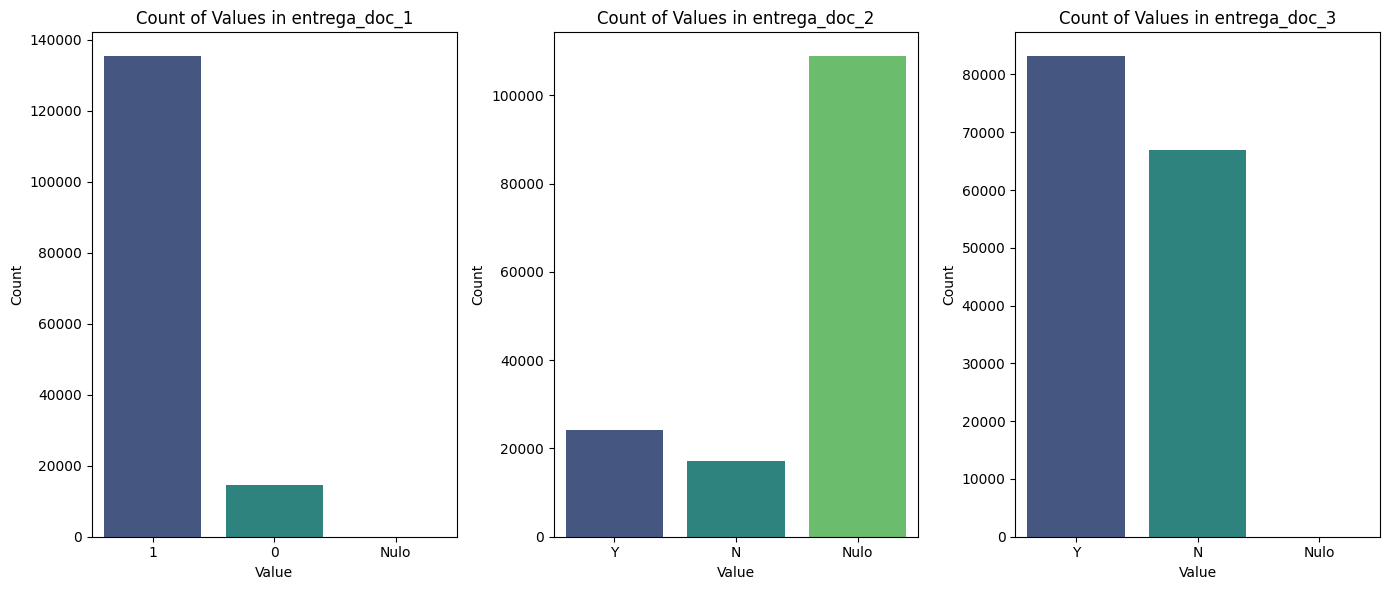

In [69]:
# Lista das colunas de entrega
doc_delivery_cols = ['entrega_doc_1', 'entrega_doc_2', 'entrega_doc_3']

# Configuração da figura para os gráficos de barras
plt.figure(figsize=(14, 6))

# Criação dos gráficos de barras
for i, col in enumerate(doc_delivery_cols, 1):
    plt.subplot(1, 3, i)
    col_count = df[col].value_counts(dropna=False)
    null_count = col_count.loc[col_count.index.isnull()].sum() if col_count.index.isnull().any() else 0
    col_count = col_count[col_count.index.notnull()]
    col_count['Nulo'] = null_count
    sns.barplot(x=col_count.index.astype(str), y=col_count.values, palette='viridis')
    plt.title(f'Count of Values in {col}')
    plt.xlabel('Value')
    plt.ylabel('Count')

# Ajuste da figura para evitar sobreposição
plt.tight_layout()
plt.show()

Com esses gráficos é possível verificar a distribuição dos valores em cada coluna, entendendo suas diferenças de valores e representações (o que está como 1 em uma coluna está como Y nas outras, e também a grande quantidade de nulos em `entrega_doc_2`, que serão considerados como não entregues).

Pra finalizar a parte de análise das variáveis categóricas, vamos entender como nossa variável target está ditribuída.

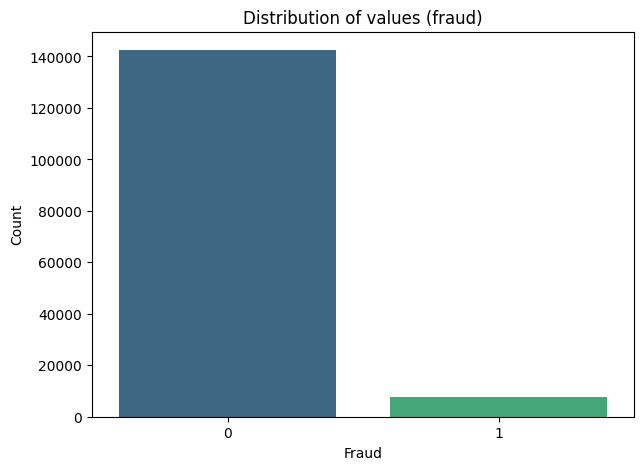

In [70]:
# Gráfico de distribuição dos valores de fraude
plt.figure(figsize=(7, 5))
sns.countplot(data=df, x='fraude', palette='viridis')
plt.title('Distribution of values (fraud)')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.show()

In [18]:
# Percentual de fraude e não fraudes
df['fraude'].value_counts(normalize=True) * 100

fraude
0    95.0
1     5.0
Name: proportion, dtype: float64

Como é esperado, o dataset é desbalanceado em relação à variável target, o que exige um balanceamento para treinamento do modelo que será criado.

## Variáveis Numéricas

Para iniciar a análise das variáveis numéricas, vamos visualizar algumas estatísticas.

In [19]:
df.describe()

,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9,score_10,entrega_doc_1,valor_compra,score_fraude_modelo,fraude
count,150000.000000,137016.000000,1.370160e+05,149635.000000,150000.000000,149989.000000,150000.000000,150000.000000,149989.000000,149635.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,3.705407,0.728115,2.604451e+05,21.677669,0.220641,51.169352,14.193513,0.497532,2305.409403,299.969579,0.902353,43.523134,48.066240,0.050000
std,0.753206,0.132943,8.464361e+05,20.062146,2.434995,709.472904,14.161216,0.288348,1712.379601,321.075806,0.296837,91.557888,28.995122,0.217946
min,1.000000,0.000000,1.600000e-01,0.000000,0.000000,-5.000000,0.000000,0.000004,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000
25%,4.000000,0.678400,9.679915e+03,2.000000,0.000000,1.000000,3.000000,0.246819,910.000000,42.000000,1.000000,9.380000,23.000000,0.000000
50%,4.000000,0.755500,4.371165e+04,14.000000,0.104875,8.000000,9.000000,0.495990,1937.000000,193.000000,1.000000,20.610000,48.000000,0.000000
75%,4.000000,0.806500,1.454436e+05,50.000000,0.282938,33.000000,21.000000,0.746508,3445.000000,459.000000,1.000000,40.692500,73.000000,0.000000
max,4.000000,1.000000,1.387874e+07,50.000000,833.333333,145274.000000,58.000000,0.999995,7544.000000,2225.000000,1.000000,3696.350000,100.000000,1.000000


O que mais me chama a atenção inicialmente são as diferenças muito grandes entre os valores máximos em relação às médias e aos terceiros quartis (75%) de algumas variáveis, como `score_5`, `score_6` e `valor_compra` por exemplo. Isso demonstra que existem outliers sim, mas ainda não tenho certeza se vou eliminá-los.



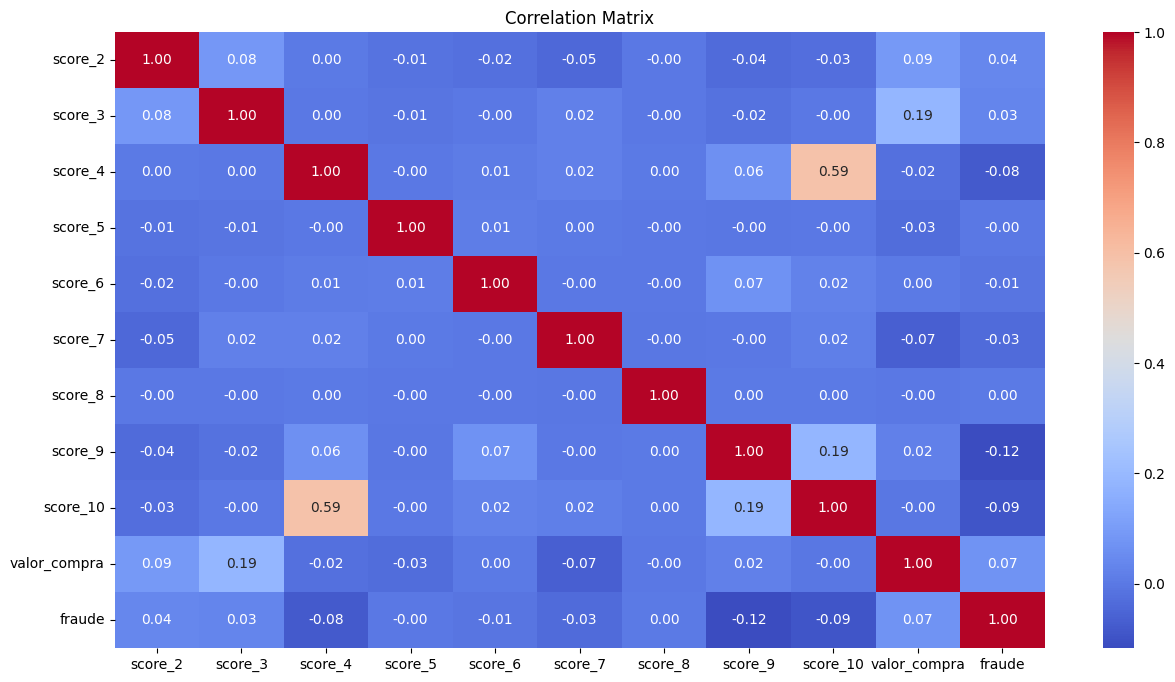

In [71]:
# Plotando uma matriz de correlação entre as variáveis numéricas
corr = df[['score_2', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_8', 'score_9', 'score_10', 'valor_compra', 'fraude']].corr()
plt.figure(figsize = (15, 8))
sns.heatmap(corr, annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.title('Correlation Matrix')
plt.show()

Existe uma correlação positiva de 0.59 entre os scores 4 e 10, que não é uma correlação forte, então não vou excluir nenhuma feature nesse caso.

Logo de início já temos um grande grupo de colunas de score (menos o `score_1` que foi considerado como variável categórica).

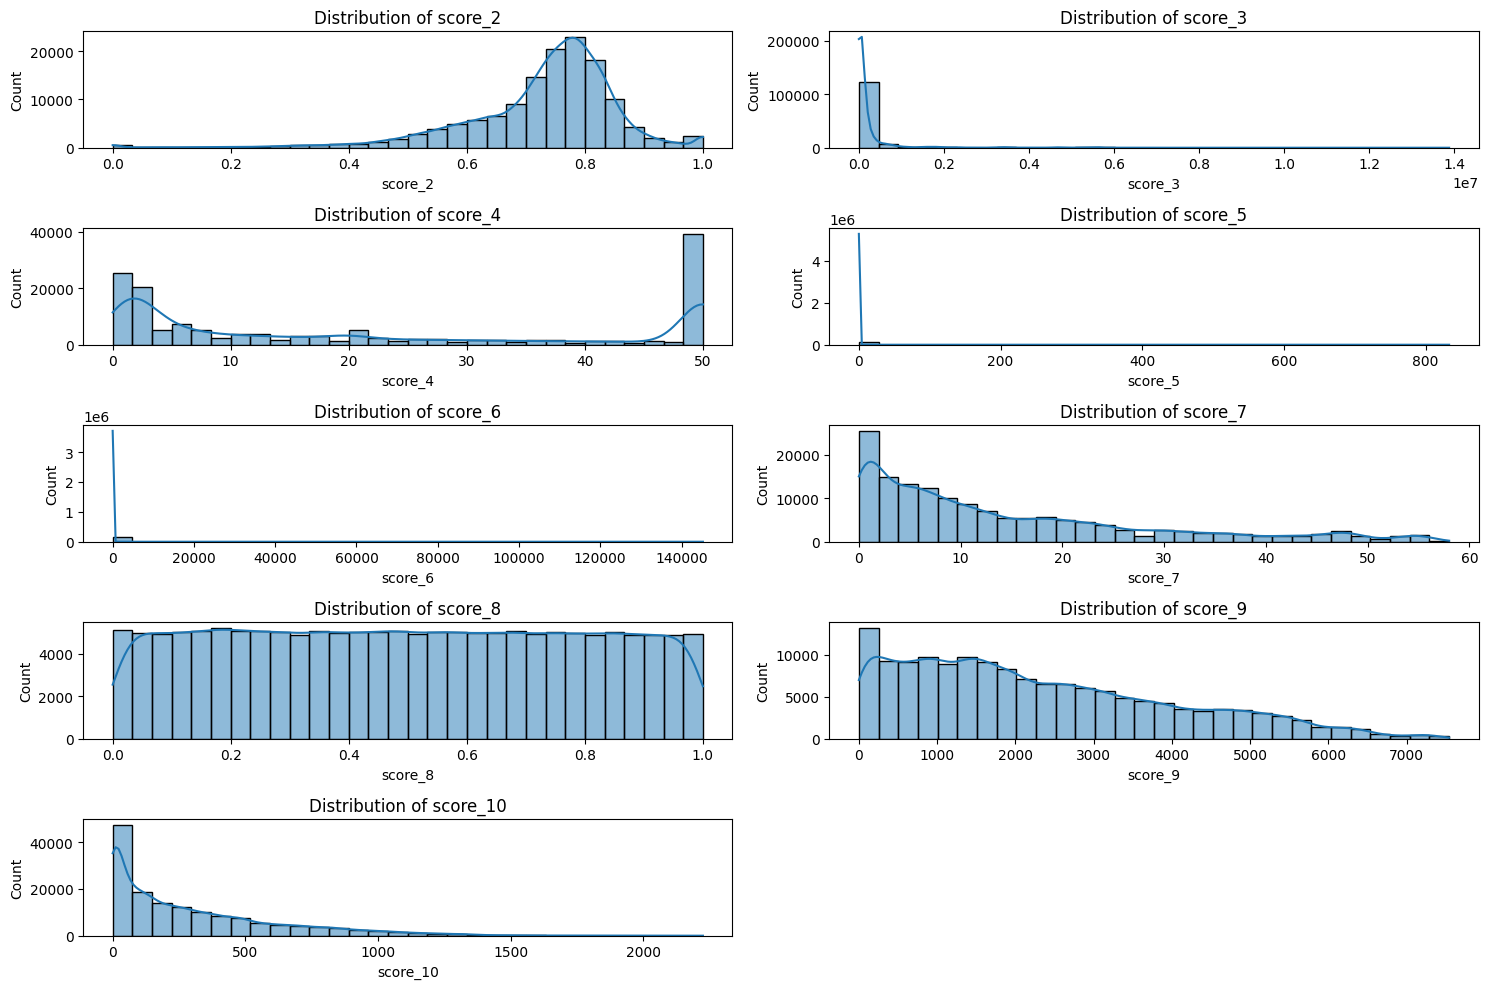

In [21]:
# Selecionando as colunas que quero entender melhor sobre a ditribuição
score_columns = ['score_2', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_8', 'score_9', 'score_10']

# Plotando histogramas
plt.figure(figsize=(15, 10))
for i, col in enumerate(score_columns, 1):
    plt.subplot(5, 2, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

Verificando os histogramas, é bem perceptível que os dados das colunas de score não estão na mesma escala e nem no formato de uma distribuição normal.

Cada score acaba variando bastante:
- `score_2` tem uma cauda à esquerda (concentração maior de valores à direita);
- `score_4` segue uma distribuição bimodal (dois picos nas duas extremidades nesse caso);
- `score_3`, `score_5`, `score_7`, `score_9` e `score_10` tem uma cauda à direita (concentração maior de valores à esquerda);
- `score_8` é o que mais me chama a atenção, com uma distribuição uniforme, o que é péssimo para o modelo que iremos construir, visto que os dados não tem quase nenhuma variação, sendo muito difícil de identificar um padrão de comportamento baseado nessa variável.


Na parte de tratamento dos dados, provavelmente irei eliminar o `score_8` pelo motivo citado acima. Referente às outras colunas de score, como não sabemos exatamente o que cada uma representa, por estarem anonimizadas, fica um pouco mais complicado de ter certeza se valores muito acima ou abaixo da média serão outliers impossíveis de ocorrer em uma situação real, e por isso vou mantê-los posteriormente.

Agora vou verificar a distribuição dos valores de compra, pra entender se existe algum padrão ou comportamento significativo no conjunto de dados.

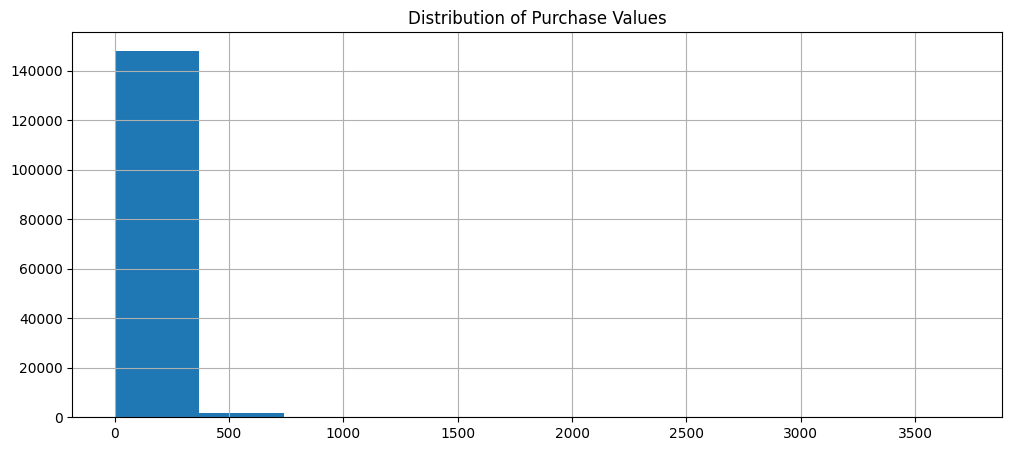

In [72]:
# Gráfico de distribuição dos valores de compra
fig, ax = plt.subplots(figsize = (12, 5))
ax.set_title('Distribution of Purchase Values')
df['valor_compra'].hist(ax = ax);

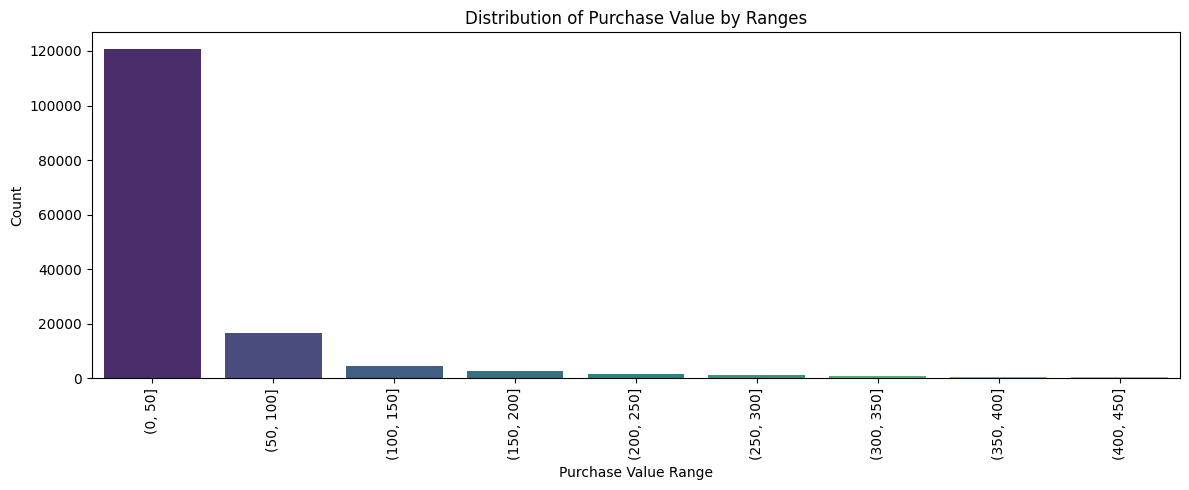

In [73]:
# Definir as faixas para os valores de compra
bins = range(0, 500, 50)

# Contar os valores em cada faixa
range_count = pd.cut(df['valor_compra'], bins).value_counts().sort_index()

# Plotar o gráfico de barras
plt.figure(figsize=(12, 5))
sns.barplot(x=range_count.index.astype(str), y=range_count.values, palette='viridis')
plt.xticks(rotation=90)
plt.title('Distribution of Purchase Value by Ranges')
plt.xlabel('Purchase Value Range')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Com os gráficos acima foi possível perceber que a maioria das compras foi com menos de 150 dólares, o que torna os valores próximos de 3700, outliers suspeitos.

# Análise Exploratória Bivariada

Ao explorar as variáveis de maneira univariada, fui pensando em algumas hipóteses que podem ser testadas. Como não temos muitas colunas no dataset, irei separar elas em grupos e verificar se existe alguma relação entre cada coluna com a variável target. Com isso, temos as seguinte hipóteses:
- Existe alguma relação entre as variáveis de score e fraude?
- Existe alguma relação entre país e fraude?
- Existe alguma relação entre as entregas de documentos e fraude?
- Existe alguma relação entre a data da compra e fraude?
- Existe alguma relação entre o valor da compra e fraude?

Vou iniciar com um pairplot para tentar visualizar algum padrão nos casos de fraude, em relação às outras colunas.

In [24]:
df_subset = df[['score_3', 'score_5', 'score_6', 'score_9', 'entrega_doc_1', 'valor_compra', 'fraude']].copy()

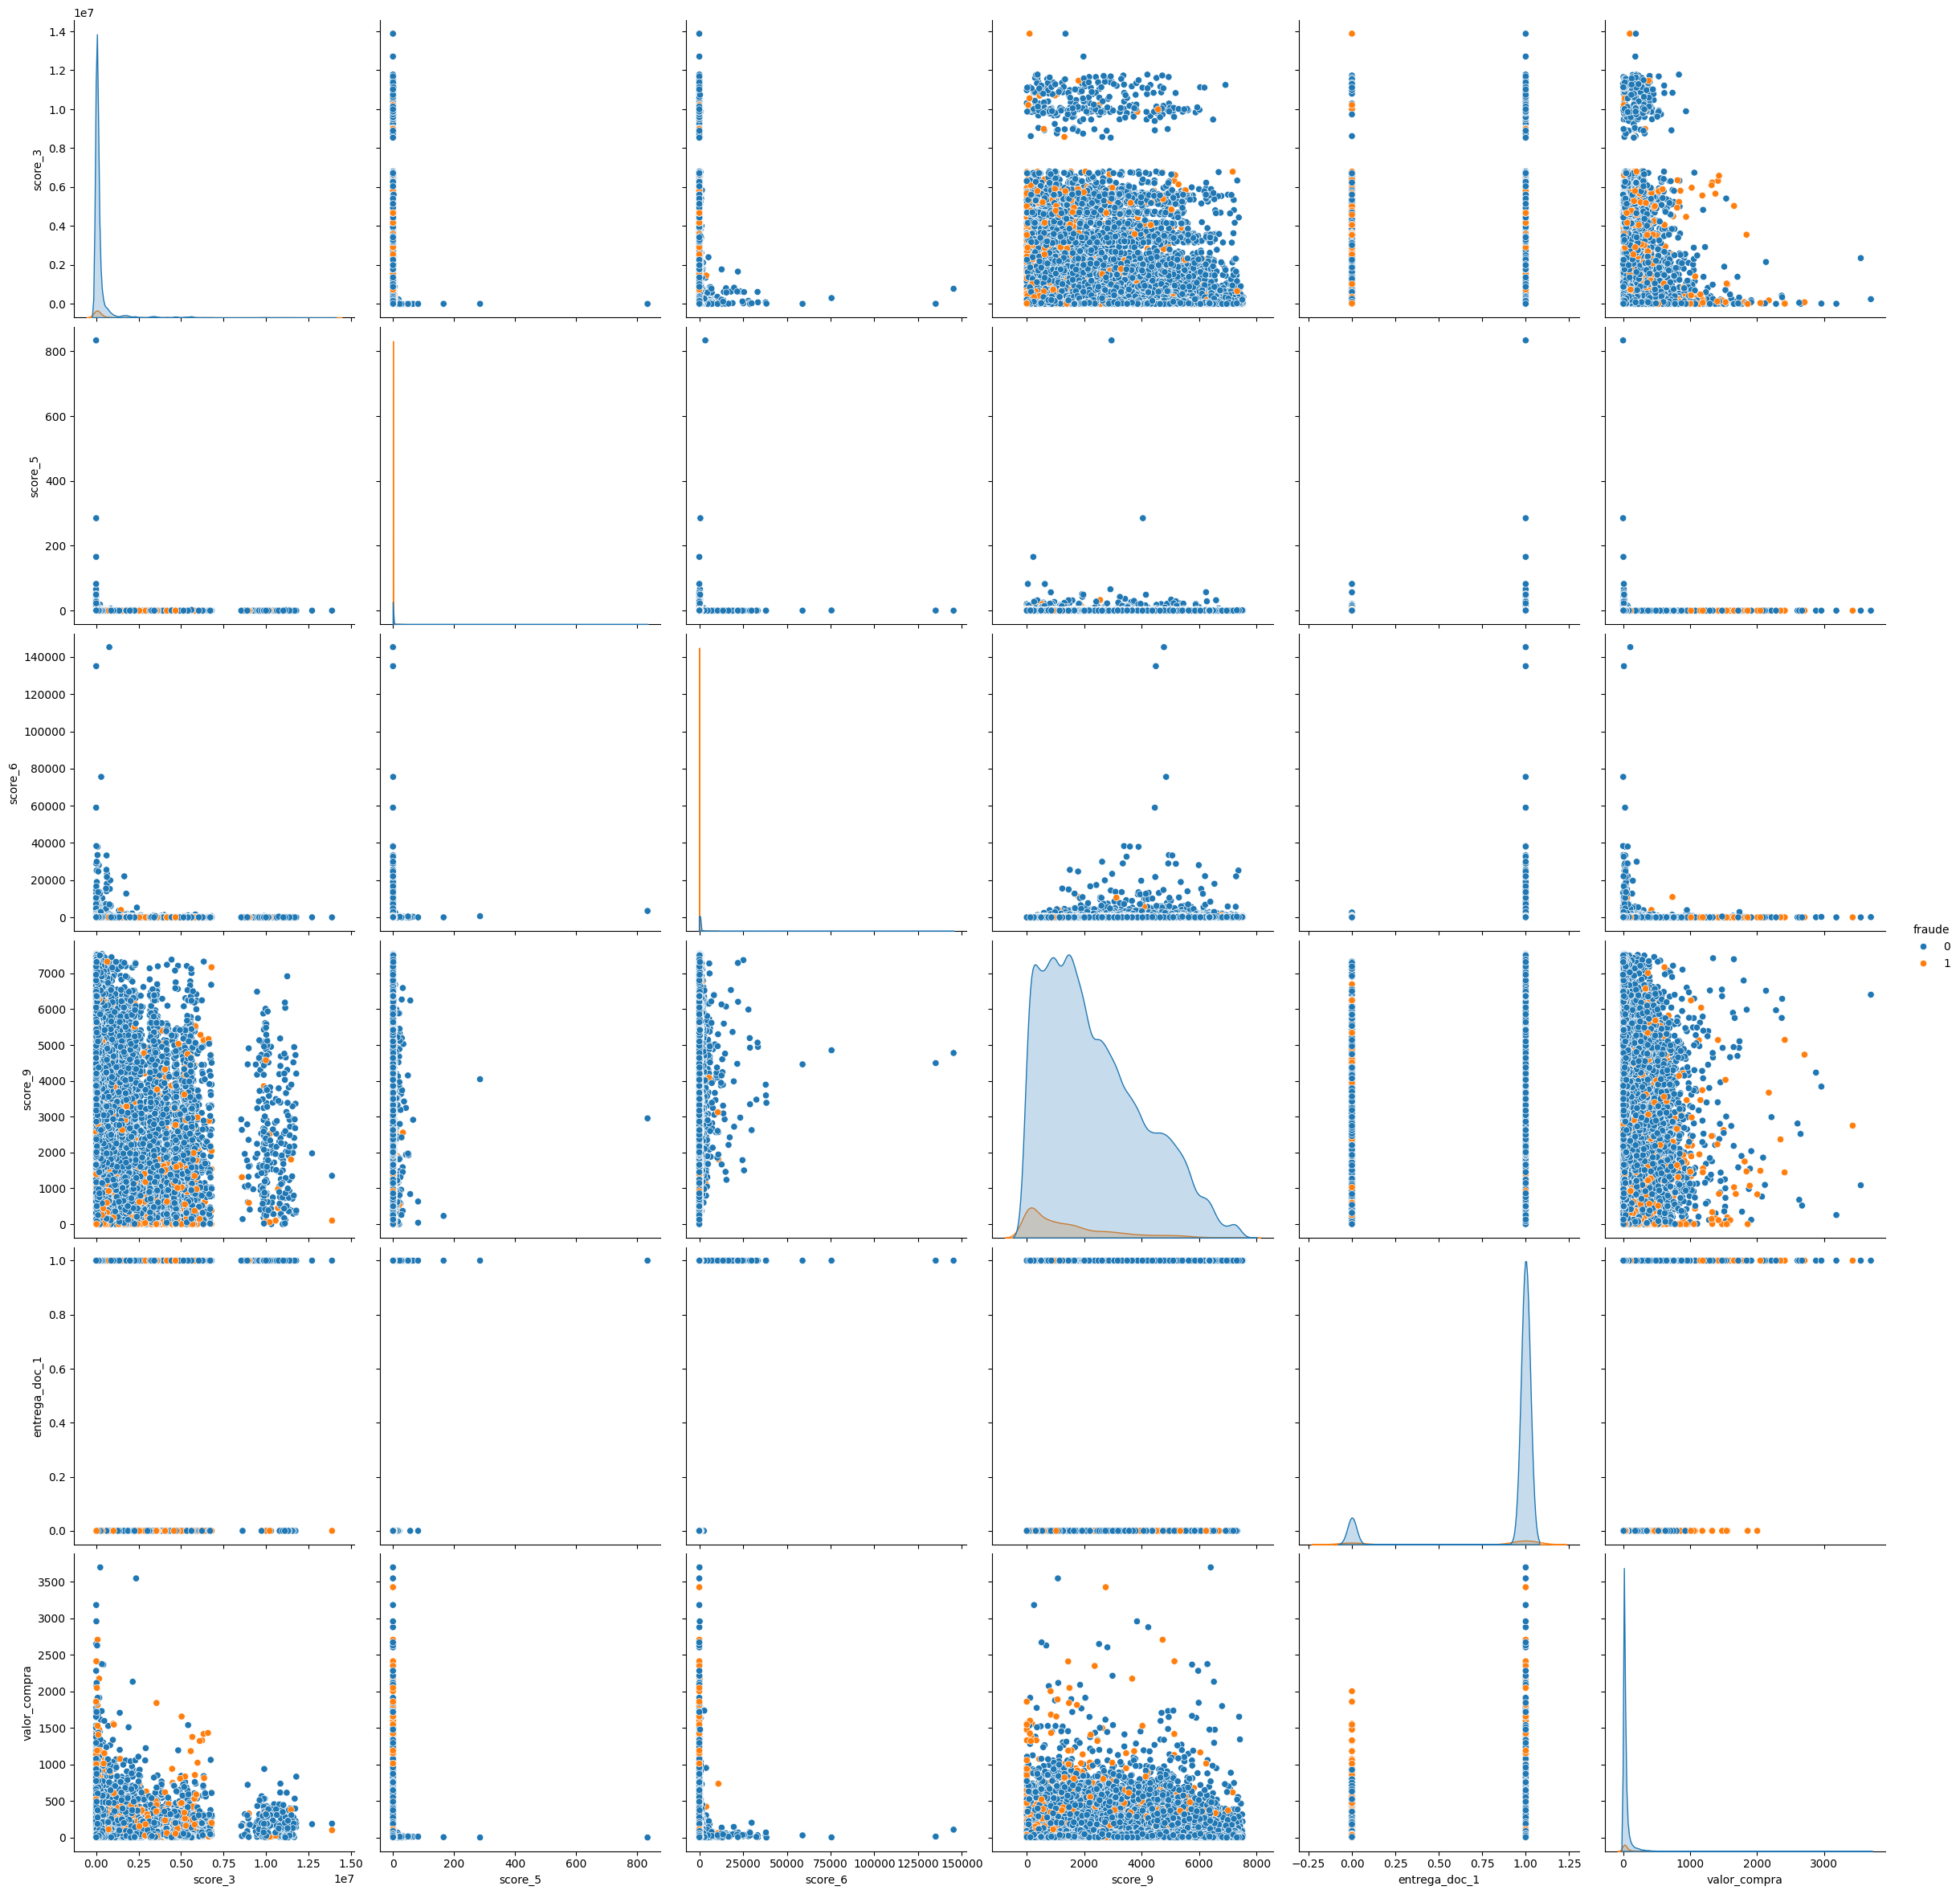

In [25]:
# Gerando os gráficos de dispersão
sns.pairplot(df_subset, hue = 'fraude', height = 4)
plt.show()

Pelo pairplot não foi possível identificar nenhuma relação significativa entre fraude e valores determinados de alguma variável.

Então vou tentar encontrar alguma relação entre as variáveis de score com a target. Como eu já visualizei as distribuições de valores para cada variável anteriormente, agora vou focar nos testes de hipótese, iniciando com o `score_1` por ser categórico, e depois partindo para os outros scores.

In [26]:
# Criando uma tabela de contingência
contingency_table = pd.crosstab(df['score_1'], df['fraude'])

# Executando o teste Qui-Quadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Exibindo os resultados
print("Estatística Qui-Quadrado:", chi2)
print("P-valor:", p)
print("Graus de liberdade:", dof)
print("Tabela Esperada:")
print(expected)

# Verificando a hipótese nula
alpha = 0.05
if p < alpha:
    print("Rejeitamos a hipótese nula: Existe uma relação significativa entre 'score_1' e 'fraude'.")
else:
    print("Não rejeitamos a hipótese nula: Não há evidência suficiente para afirmar que 'score_1' e 'fraude' estão relacionados.")

Estatística Qui-Quadrado: 584.4465798546843
P-valor: 2.371872621590785e-126
Graus de liberdade: 3
Tabela Esperada:
[[  3985.25    209.75]
 [ 13659.1     718.9 ]
 [  2705.6     142.4 ]
 [122150.05   6428.95]]
Rejeitamos a hipótese nula: Existe uma relação significativa entre 'score_1' e 'fraude'.


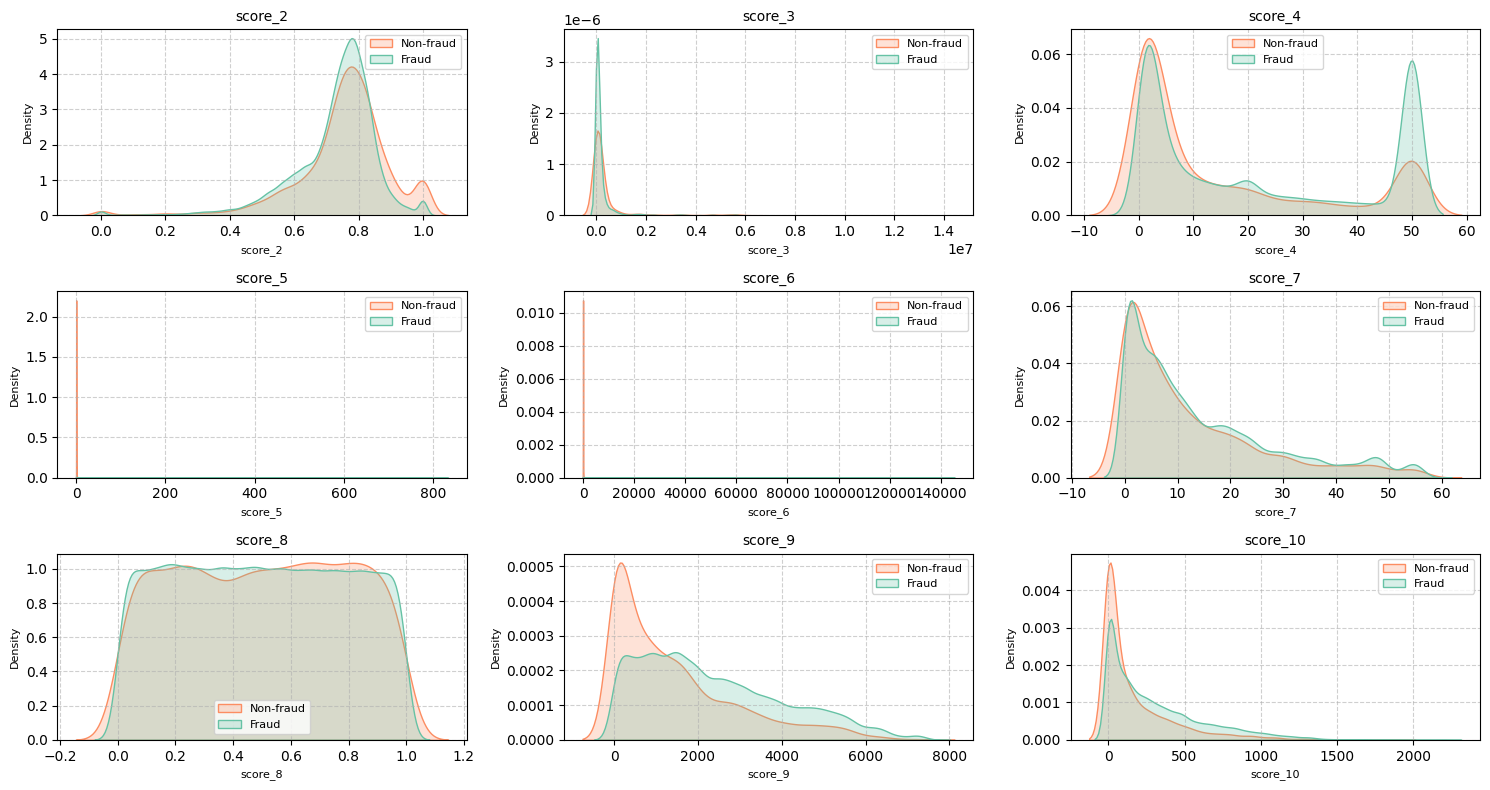

In [74]:
# Criando uma grade de subplots
fig, axes = plt.subplots(nrows=(len(score_columns) + 2) // 3, ncols=3, figsize=(15, 8))
axes = axes.flatten()

# Criando gráficos de densidade para cada variável
for i, col in enumerate(score_columns):
    sns.kdeplot(data=df, x=col, hue='fraude', common_norm=False, fill=True, palette="Set2", ax=axes[i])
    axes[i].set_title(f'{col}', fontsize=10)
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].set_ylabel('Density', fontsize=8)
    axes[i].legend(labels=["Non-fraud", "Fraud"], fontsize=8)
    axes[i].grid(visible=True, linestyle='--', alpha=0.6)

# Removendo eixos extras
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [28]:
# Iterar sobre as variáveis numéricas e realizar o teste KS
for col in score_columns:
    # Removendo valores nulos antes do teste
    data_fraud = df[df['fraude'] == 1][col].dropna()
    data_not_fraud = df[df['fraude'] == 0][col].dropna()
    
    # Verificando se ambas as amostras possuem valores suficientes
    if len(data_fraud) < 2 or len(data_not_fraud) < 2:
        print(f"Variável: {col}")
        print("Teste KS não pode ser realizado: uma das amostras tem menos de 2 valores.\n")
        continue

    # Teste KS
    ks_stat, p_value = ks_2samp(data_fraud, data_not_fraud)
    
    # Exibindo os resultados
    print(f"Variável: {col}")
    print(f"Estatística KS: {ks_stat:.4f}")
    print(f"P-Valor: {p_value:.4f}")
    
    # Verificando hipótese nula
    alpha = 0.05
    if p_value < alpha:
        print("Rejeitamos a hipótese nula: Há diferença significativa entre os grupos.\n")
    else:
        print("Não rejeitamos a hipótese nula: Não há evidência suficiente para afirmar diferença entre os grupos.\n")

Variável: score_2
Estatística KS: 0.1038
P-Valor: 0.0000
Rejeitamos a hipótese nula: Há diferença significativa entre os grupos.

Variável: score_3
Estatística KS: 0.0506
P-Valor: 0.0000
Rejeitamos a hipótese nula: Há diferença significativa entre os grupos.

Variável: score_4
Estatística KS: 0.1664
P-Valor: 0.0000
Rejeitamos a hipótese nula: Há diferença significativa entre os grupos.

Variável: score_5
Estatística KS: 0.0844
P-Valor: 0.0000
Rejeitamos a hipótese nula: Há diferença significativa entre os grupos.

Variável: score_6
Estatística KS: 0.2778
P-Valor: 0.0000
Rejeitamos a hipótese nula: Há diferença significativa entre os grupos.

Variável: score_7
Estatística KS: 0.0857
P-Valor: 0.0000
Rejeitamos a hipótese nula: Há diferença significativa entre os grupos.

Variável: score_8
Estatística KS: 0.0122
P-Valor: 0.2407
Não rejeitamos a hipótese nula: Não há evidência suficiente para afirmar diferença entre os grupos.

Variável: score_9
Estatística KS: 0.2530
P-Valor: 0.0000
Rejei

Para quase todos os scores nós rejeitamos a hipótese nula, demonstrando que existe uma relação ou diferença significativa entre as variáveis e o fato de ser fraude ou não. Quase todos pois apenas para o `score_8` não rejeitamos a hipótese nula, visto que a distribuição de valores para fraude e não fraude são muito parecidos, como já tínhamos verificado anteriormente, o que comprova que essa não é uma feature interessante para ser usada no treinamento do modelo.

Agora vou verificar a hipótese nula para a relação entre país e fraude.

In [29]:
# Criando uma tabela de contingência
contingency_table = pd.crosstab(df['pais'], df['fraude'])

# Executando o teste Qui-Quadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Exibindo os resultados
print("Estatística Qui-Quadrado:", chi2)
print("P-valor:", p)
print("Graus de liberdade:", dof)

# Verificando a hipótese nula
alpha = 0.05
if p < alpha:
    print("Rejeitamos a hipótese nula: Existe uma relação significativa entre 'pais' e 'fraude'.")
else:
    print("Não rejeitamos a hipótese nula: Não há evidência suficiente para afirmar que 'pais' e 'fraude' estão relacionados.")

Estatística Qui-Quadrado: 435.0414968257157
P-valor: 7.757972296868586e-63
Graus de liberdade: 50
Rejeitamos a hipótese nula: Existe uma relação significativa entre 'pais' e 'fraude'.


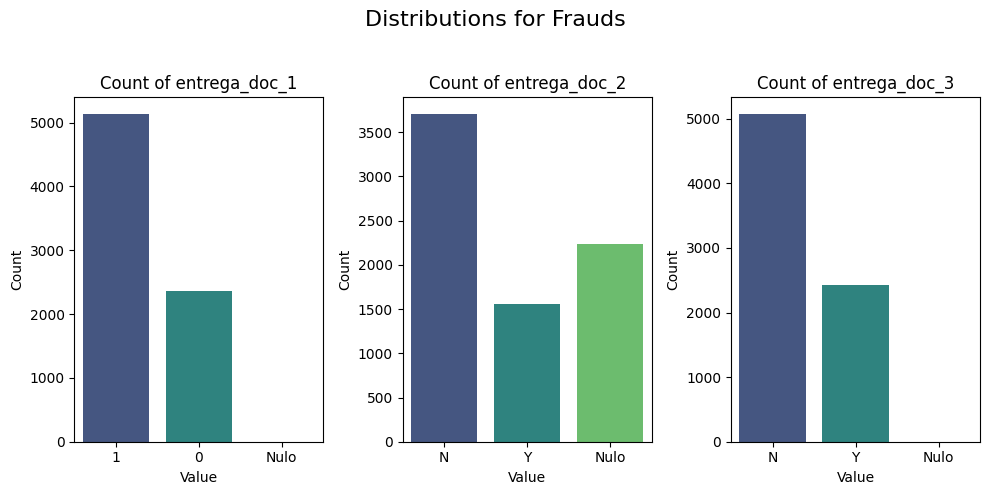

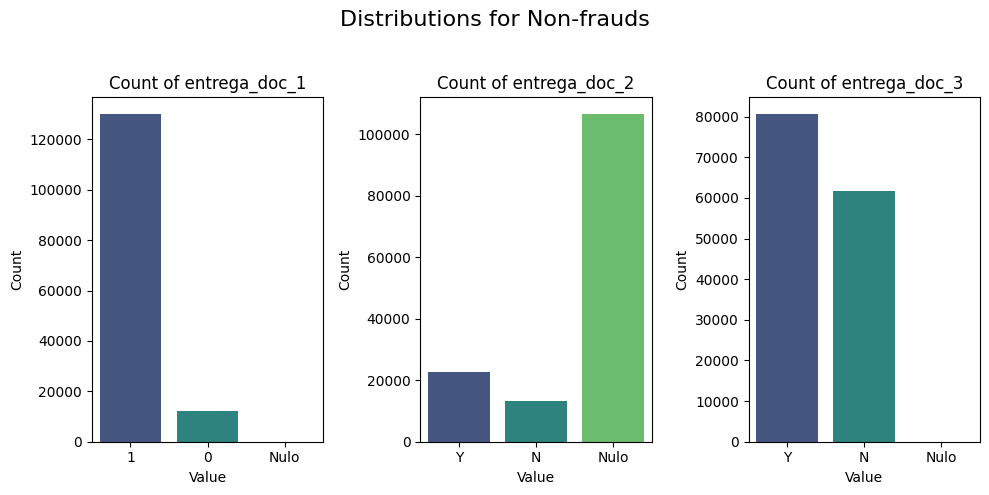

In [76]:
# Criando figuras separadas para fraudes e não fraudes
for label, subset in [('Frauds', df[df['fraude'] == 1]), ('Non-frauds', df[df['fraude'] == 0])]:
    # Configuração da figura para os gráficos de barras
    plt.figure(figsize=(10, 5))
    plt.suptitle(f'Distributions for {label}', fontsize=16)
    
    # Criação dos gráficos de barras
    for i, col in enumerate(doc_delivery_cols, 1):
        plt.subplot(1, len(doc_delivery_cols), i)
        contagem = subset[col].value_counts(dropna=False)
        nulos = contagem.loc[contagem.index.isnull()].sum() if contagem.index.isnull().any() else 0
        contagem = contagem[contagem.index.notnull()]
        contagem['Nulo'] = nulos
        sns.barplot(x=contagem.index.astype(str), y=contagem.values, palette='viridis')
        plt.title(f'Count of {col}')
        plt.xlabel('Value')
        plt.ylabel('Count')
    
    # Ajuste da figura
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Com essa visualização é interessante perceber um comportamento referente ao doc 3. Na distribuição de fraudes, o dobro de pessoas não entregaram o documento em comparação com as que entregaram. Na distribuição de não fraudes essa coluna é um pouco mais balanceada, e é o contrário que ocorre, com mais pessoas entregando o documento.

In [31]:
# Iterar sobre as colunas de entrega
for col in doc_delivery_cols:
    # Criando uma tabela de contingência
    contingency_table = pd.crosstab(df[col], df['fraude'])

    # Executando o teste Qui-Quadrado
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Exibindo os resultados
    print(f"\nColuna: {col}")
    print("Estatística Qui-Quadrado:", chi2)
    print("P-valor:", p)
    print("Graus de liberdade:", dof)

    # Verificando a hipótese nula
    alpha = 0.05
    if p < alpha:
        print("Rejeitamos a hipótese nula: Existe uma relação significativa entre a coluna e 'fraude'.")
    else:
        print("Não rejeitamos a hipótese nula: Não há evidência suficiente para afirmar que a coluna e 'fraude' estão relacionadas.")


Coluna: entrega_doc_1
Estatística Qui-Quadrado: 4217.317158934374
P-valor: 0.0
Graus de liberdade: 1
Rejeitamos a hipótese nula: Existe uma relação significativa entre a coluna e 'fraude'.

Coluna: entrega_doc_2
Estatística Qui-Quadrado: 2093.9742824255336
P-valor: 0.0
Graus de liberdade: 1
Rejeitamos a hipótese nula: Existe uma relação significativa entre a coluna e 'fraude'.

Coluna: entrega_doc_3
Estatística Qui-Quadrado: 1709.9413003678396
P-valor: 0.0
Graus de liberdade: 1
Rejeitamos a hipótese nula: Existe uma relação significativa entre a coluna e 'fraude'.


Agora eu vou analisar se existe alguma relação entre os dados temporais que temos no dataframe com a variável target.

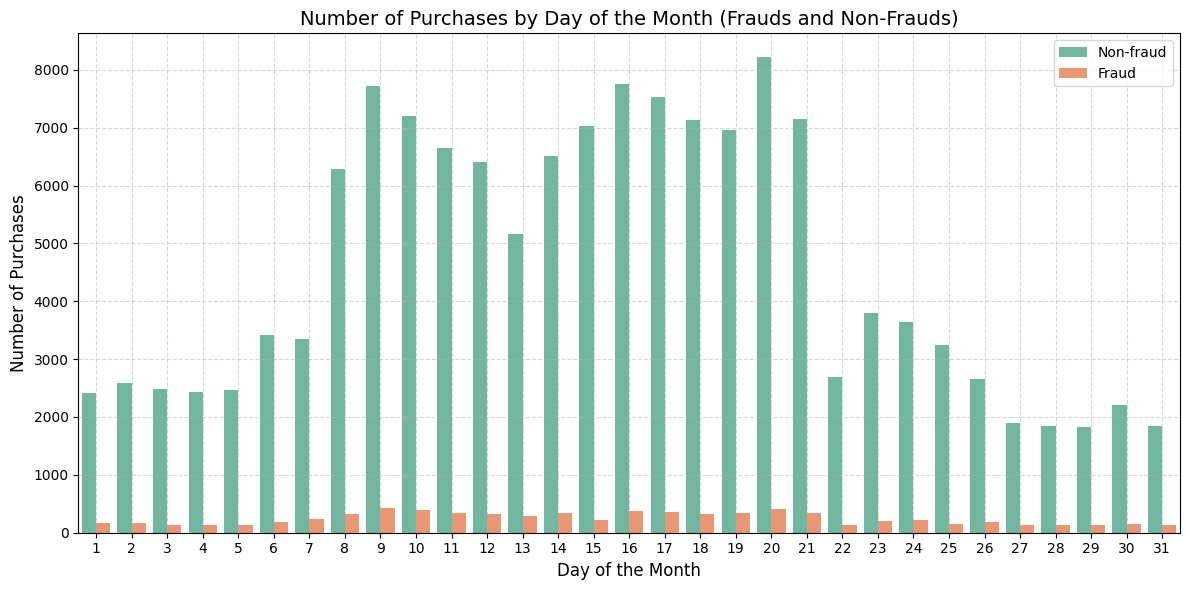

In [77]:
# Extraindo os dias do mês e as horas da coluna 'data_compra'
df_copy = df.copy()

df_copy['dia_do_mes'] = pd.to_datetime(df_copy['data_compra']).dt.day
df_copy['hora'] = pd.to_datetime(df_copy['data_compra']).dt.hour

# Agrupando os dados para contar fraudes e não fraudes por dia do mês
purchases_per_day = df_copy.groupby(['dia_do_mes', 'fraude']).size().reset_index(name='quantidade')

# Criando o gráfico
plt.figure(figsize=(12, 6))
palette = sns.color_palette("Set2", n_colors=2)
sns.barplot(data=purchases_per_day, x='dia_do_mes', y='quantidade', hue='fraude', palette=palette)
plt.title('Number of Purchases by Day of the Month (Frauds and Non-Frauds)', fontsize=14)
plt.xlabel('Day of the Month', fontsize=12)
plt.ylabel('Number of Purchases', fontsize=12)
fraude_labels = {0: 'Non-fraud', 1: 'Fraud'}
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, [fraude_labels[int(label)] for label in labels])
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

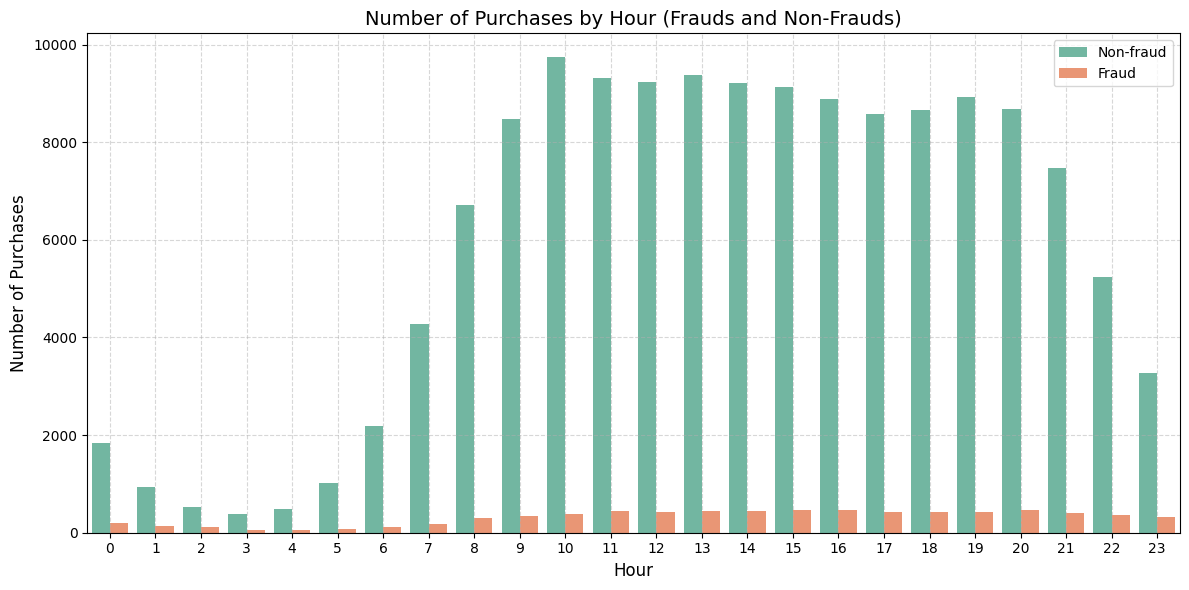

In [78]:
# Agrupando os dados para contar fraudes e não fraudes por hora
purchases_per_hour = df_copy.groupby(['hora', 'fraude']).size().reset_index(name='quantidade')

# Criando o gráfico
plt.figure(figsize=(12, 6))
palette = sns.color_palette("Set2", n_colors=2)
sns.barplot(data=purchases_per_hour, x='hora', y='quantidade', hue='fraude', palette=palette)
plt.title('Number of Purchases by Hour (Frauds and Non-Frauds)', fontsize=14)
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Number of Purchases', fontsize=12)
fraude_labels = {0: 'Non-fraud', 1: 'Fraud'}
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, [fraude_labels[int(label)] for label in labels])
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [34]:
# Criando uma tabela de contingência
contingency_table = pd.crosstab(df_copy['dia_do_mes'], df_copy['fraude'])

# Executando o teste Qui-Quadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Exibindo os resultados
print("Estatística Qui-Quadrado:", chi2)
print("P-valor:", p)
print("Graus de liberdade:", dof)

# Verificando a hipótese nula
alpha = 0.05
if p < alpha:
    print("Rejeitamos a hipótese nula: Existe uma relação significativa entre 'dia_do_mes' e 'fraude'.")
else:
    print("Não rejeitamos a hipótese nula: Não há evidência suficiente para afirmar que 'dia_do_mes' e 'fraude' estão relacionados.")

Estatística Qui-Quadrado: 176.07910490044085
P-valor: 1.3308511585064855e-22
Graus de liberdade: 30
Rejeitamos a hipótese nula: Existe uma relação significativa entre 'dia_do_mes' e 'fraude'.


In [35]:
# Criando uma tabela de contingência
contingency_table = pd.crosstab(df_copy['hora'], df_copy['fraude'])

# Executando o teste Qui-Quadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Exibindo os resultados
print("Estatística Qui-Quadrado:", chi2)
print("P-valor:", p)
print("Graus de liberdade:", dof)

# Verificando a hipótese nula
alpha = 0.05
if p < alpha:
    print("Rejeitamos a hipótese nula: Existe uma relação significativa entre 'hora' e 'fraude'.")
else:
    print("Não rejeitamos a hipótese nula: Não há evidência suficiente para afirmar que 'hora' e 'fraude' estão relacionados.")

Estatística Qui-Quadrado: 841.6593861727897
P-valor: 5.3030288311866235e-163
Graus de liberdade: 23
Rejeitamos a hipótese nula: Existe uma relação significativa entre 'hora' e 'fraude'.


Em relação às variáveis temporais (dia do mês e hora da compra), apesar de ambas apresentarem uma relação significativa com a target fraude, não acho que seja interessante levá-las para o treinamento do modelo por acrescentarem alguns pontos de complexidade que não fariam sentido para o projeto.

Por exemplo, se o modelo perceber que muitas transações fraudulentas são realizadas em um período da madrugada, ele poderá bloquear muitas transações naqueles horários, "alertando" os golpistas que automaticamente irão mudar suas estratégias, fazendo compras em horários alternativos. Assim o modelo precisaria se reajustar para entender essa dinâmica. Por isso vamos manter essas variáveis de fora.

A última hipótese que eu gostaria de testar é da relação entre o valor da compra e a variável fraude. Para isso, irei utilizar o método Mann-Whitney U Test, que é apropriado quando não se pode assumir normalidade na distribuição dos dados. No caso do valor da compra, que pode ter uma distribuição não normal e valores extremos (outliers), este teste é mais robusto e confiável.

In [36]:
# Separando os valores de compra por categoria de fraude
fraud_values = df[df['fraude'] == 1]['valor_compra']
non_fraud_values = df[df['fraude'] == 0]['valor_compra']

# Realizando o teste Mann-Whitney U
stat, p = mannwhitneyu(fraud_values, non_fraud_values, alternative='two-sided')

# Exibindo os resultados
print("Estatística U:", stat)
print("P-valor:", p)

# Verificando a hipótese nula
alpha = 0.05
if p < alpha:
    print("Rejeitamos a hipótese nula: Existe uma relação significativa entre 'valor_compra' e 'fraude'.")
else:
    print("Não rejeitamos a hipótese nula: Não há evidência suficiente para afirmar que 'valor_compra' e 'fraude' estão relacionados.")

Estatística U: 605362835.0
P-valor: 5.049078387837292e-84
Rejeitamos a hipótese nula: Existe uma relação significativa entre 'valor_compra' e 'fraude'.


# Divisão do Conjunto de Dados

Antes de realizar o pré-processamento, é importante separar o dataframe em dados de treino e teste para garantir que o modelo seja treinado e avaliado de maneira eficaz. Isso é fundamental porque a separação precoce evita que o modelo tenha acesso a dados futuros durante o treinamento, o que pode levar a uma avaliação superestimada de seu desempenho.

A separação dos dados ajuda a mitigar o risco de overfitting (sobreajuste), que ocorre quando o modelo aprende excessivamente os detalhes e o ruído dos dados de treinamento, tornando-se muito específico e incapaz de generalizar para novos dados. O underfitting (subajuste), por outro lado, ocorre quando o modelo é muito simples ou não consegue capturar padrões importantes dos dados, resultando em um desempenho abaixo do esperado, tanto nos dados de treino quanto nos dados de teste.

Ao separar os dados antes do pré-processamento, garantimos que as métricas de desempenho, como precisão e recall, sejam avaliadas de forma justa e representem a verdadeira capacidade do modelo em dados não vistos.

In [37]:
# Função de separação do dataframe para testes futuros com todas as colunas
def split_df(df):
  df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
  return df_train, df_test

df_train, df_test = split_df(df)

X_train = df_train.drop('fraude', axis=1)
y_train = df_train.fraude

X_test = df_test.drop('fraude', axis=1)
y_test = df_test.fraude

# Exibindo as formas das divisões
print(f"Shape dos dados de treino (X_train): {X_train.shape}")
print(f"Shape dos dados de teste (X_test): {X_test.shape}")

Shape dos dados de treino (X_train): (120000, 19)
Shape dos dados de teste (X_test): (30000, 19)


# Modelo Baseline

Agora vamos analisar os resultados que o modelo anterior conseguiu atingir, para saber qual o nosso threshold, ou seja, nosso limite mínimo para superar os resultados das previsões anteriores.

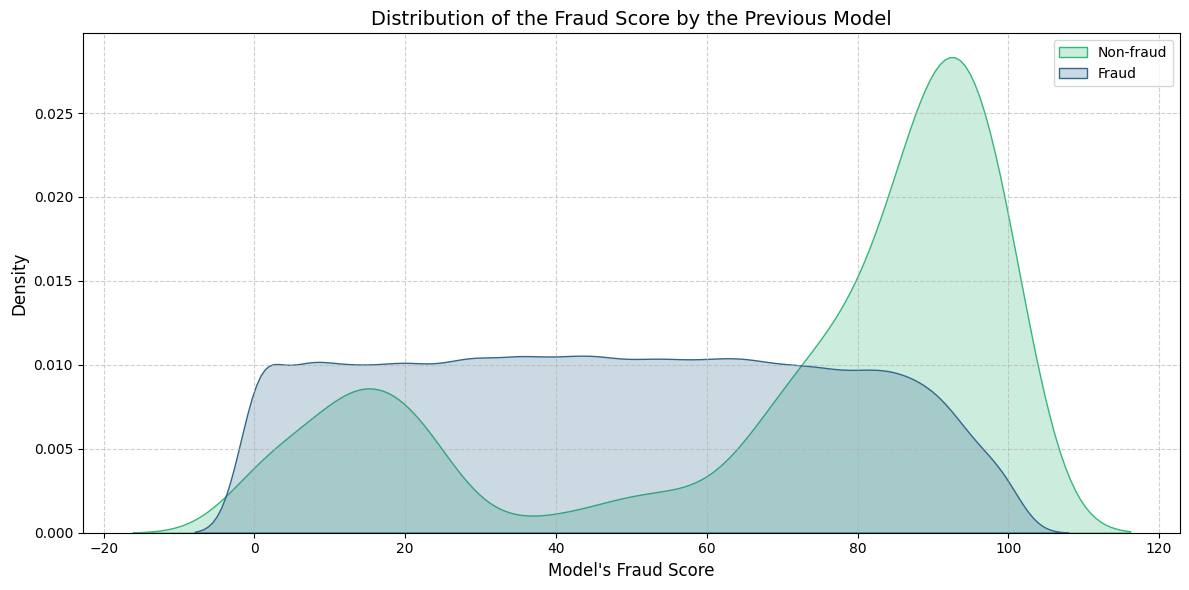

In [79]:
# Configurando o tamanho da figura
plt.figure(figsize=(12, 6))

# Plot de densidade (KDE plot)
sns.kdeplot(data=df, x='score_fraude_modelo', hue='fraude', common_norm=False, fill=True, palette='viridis')
plt.title('Distribution of the Fraud Score by the Previous Model', fontsize=14)
plt.xlabel("Model's Fraud Score", fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(labels=['Non-fraud', 'Fraud'])
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Somente pela visualização de distribuição acima, já percebemos que o modelo anterior não teve um grande desempenho, chegando a ter quase 100% de certeza que alguns registros eram fraudes, quando na verdade não eram.

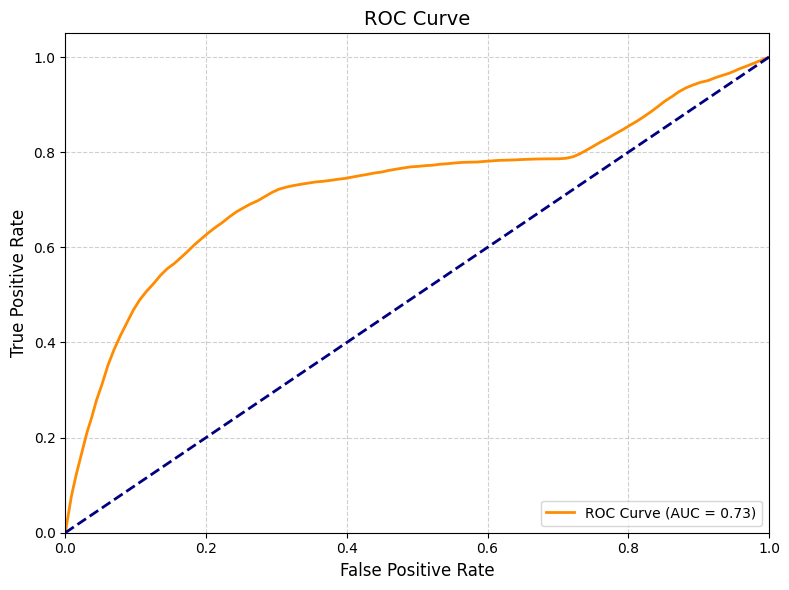

In [80]:
# Calculando as taxas de verdadeiros positivos e falsos positivos
fpr, tpr, thresholds = roc_curve(df['fraude'], df['score_fraude_modelo'])

# Calculando a AUC
auc = roc_auc_score(df['fraude'], df['score_fraude_modelo'])

# Plotando a Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14)
plt.legend(loc='lower right')
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

1. Interpretação da AUC:

- Uma AUC de 0.73 indica que o modelo tem uma capacidade moderada de discriminar entre fraudes e não fraudes. A AUC varia de 0 a 1, onde 1 representa um modelo perfeito e 0.5 representa um modelo sem poder discriminativo (equivalente a uma classificação aleatória).
- Com 0.73, o modelo atual é melhor do que uma classificação aleatória, mas ainda há espaço significativo para melhorias.

2. Curva ROC:

- A curva ROC em si mostra a relação entre a taxa de verdadeiros positivos (sensibilidade) e a taxa de falsos positivos (1 - especificidade) em diferentes limiares de classificação.
- A curva está acima da linha diagonal (linha de não discriminação), o que é bom, mas a inclinação poderia ser mais acentuada para indicar uma melhor performance.

### Pontos a Considerar:
- Melhoria do Modelo: Com uma AUC de 0.73, o modelo está acertando mais do que errando, mas é crucial entender onde ele está falhando. Analisar casos específicos de falsos positivos e falsos negativos pode ajudar a refinar o modelo.
- Balanceamento dos Dados: Certifique-se de que os dados de fraude e não fraude estão balanceados ou use técnicas de balanceamento para evitar viés no treinamento.
- Ajuste de Hiperparâmetros: Ajustar os hiperparâmetros do modelo pode levar a uma melhor performance.
- Features Adicionais: Considere a engenharia de novas features ou a transformação de features existentes para melhorar a performance do modelo.

### Métricas de business e definição de um threshold

Agora eu quero calcular quais foram os ganhos, perdas e lucros para cada valor da coluna `score_fraude_modelo`, analisando qual o valor limite (threshold) que maximiza o lucro das previsões. Esse valor servirá de comparação para o modelo posterior, que terá o trabalho de aumentar o lucro gerado por esse modelo.

Para isso, vamos considerar as informações que nos foram dadas inicialmente:
- a instituição financeira ganha 10% do valor de cada pagamento aprovado corretamente
- cada fraude aprovada resulta na perda de 100% do valor do pagamento

Com isso, conseguimos considerar a definição correta de fraude ou não fraude pela coluna `fraude`, baseada em cada valor possível da coluna `score_fraude_modelo`. Com ganhos e perdas calculados, é só fazer a subtração para termos o lucro.

O melhor threshold é: 73
O lucro máximo é: USD 54976.67


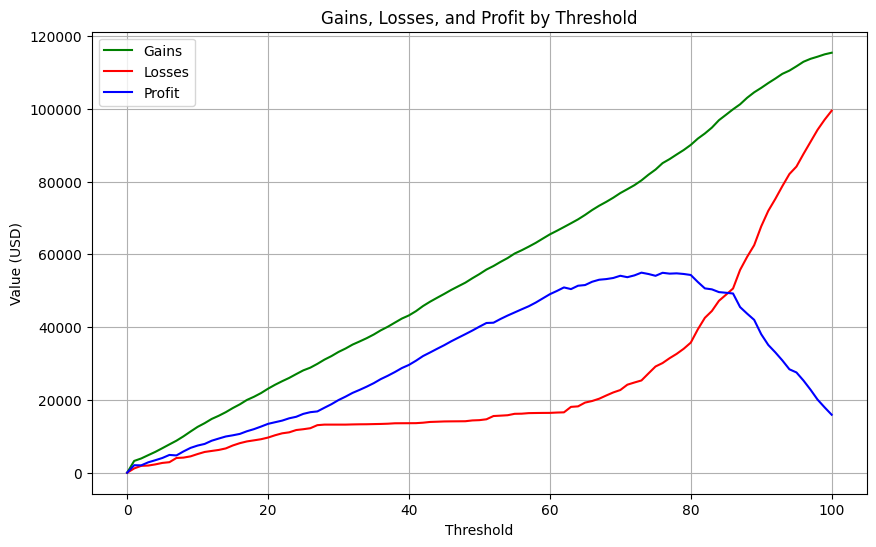

In [82]:
# Inicializando listas para armazenar os resultados
thresholds = np.arange(0, 101)
gains_list = []
losses_list = []
profit_list = []

# Calculando ganhos, perdas e lucro para cada threshold
for threshold in thresholds:
    df_test['fraude_predita'] = df_test['score_fraude_modelo'] >= threshold
    
    gains = df_test[(df_test['fraude'] == 0) & (df_test['fraude_predita'] == False)]['valor_compra'].sum() * 0.1
    losses = df_test[(df_test['fraude'] == 1) & (df_test['fraude_predita'] == False)]['valor_compra'].sum()
    profit = gains - losses
    
    gains_list.append(gains)
    losses_list.append(losses)
    profit_list.append(profit)

# Convertendo listas para um dataframe para facilitar a análise
results_df = pd.DataFrame({
    'Threshold': thresholds,
    'Ganhos': gains_list,
    'Perdas': losses_list,
    'Lucro': profit_list
})

# Encontrando o threshold que maximiza o lucro
best_threshold = results_df.loc[results_df['Lucro'].idxmax(), 'Threshold']
max_profit = results_df['Lucro'].max()

print(f'O melhor threshold é: {best_threshold}')
print(f'O lucro máximo é: USD {max_profit:.2f}')

plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Ganhos'], label='Gains', color='green')
plt.plot(results_df['Threshold'], results_df['Perdas'], label='Losses', color='red')
plt.plot(results_df['Threshold'], results_df['Lucro'], label='Profit', color='blue')
plt.xlabel('Threshold')
plt.ylabel('Value (USD)')
plt.title('Gains, Losses, and Profit by Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
# Visualizando o dataframe do gráfico
results_df

,Threshold,Ganhos,Perdas,Lucro
0,0,0.000,0.00,0.000
1,1,3242.109,1181.23,2060.879
2,2,3917.883,1890.99,2026.893
3,3,4829.258,1969.12,2860.138
4,4,5726.876,2288.36,3438.516
...,...,...,...,...
96,96,112932.551,87603.24,25329.311
97,97,113735.367,90925.22,22810.147
98,98,114322.705,94238.31,20084.395
99,99,114967.326,97012.02,17955.306


In [42]:
results_df[results_df['Threshold'] == 73]

,Threshold,Ganhos,Perdas,Lucro
73,73,80329.995,25353.32,54976.675


In [43]:
print(f'Razão de lucro: {54976.675 / 80329.995}')

Razão de lucro: 0.6843853905381172


Com as visualizações acima descobrimos que o valor da coluna `score_fraude_modelo` que maximizava os lucros era 73, que nesse caso gerou mais de 80 mil dólares de ganhos, porém gerou mais de 25 mil dólares de perdas, totalizando aproximadamente 55 mil dólares de lucro. É importante lembrar que para esse cálculo foi utilizada uma amostra do dataframe, então se pegarmos uma amostra maior, o lucro certamente será maior também.

O importante é fazer essa comparação com o modelo que será contruído posteriormente, com uma amostra de dados do mesmo tamanho, confirmando que as novas previsões superam os lucros gerados pelo modelo anterior.

Agora vamos seguir com uma matriz de confusão, ainda usando os dados de teste separados somente para a análise do modelo baseline.

In [44]:
df_test['predicted'] = df_test['score_fraude_modelo'] >= best_threshold
cm = confusion_matrix(df_test['fraude'], df_test['predicted'])

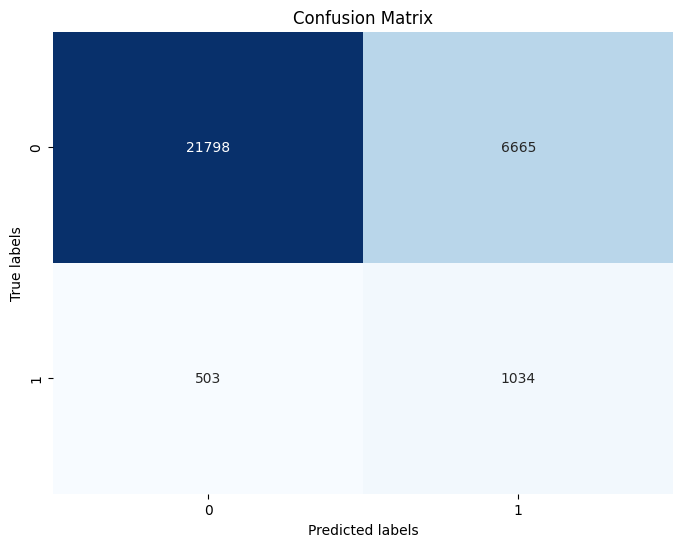

In [45]:
def plot_confusion_matrix(cm):
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()
  
plot_confusion_matrix(cm)

In [46]:
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

fraud_rate = round(FN / (FN + TN), 2)
approval_rate = round((FN + TN) / (TN + FP + TP + FN), 2)

print(f'Taxa de fraude = {fraud_rate}')
print(f'Taxa de aprovação = {approval_rate}')

Taxa de fraude = 0.02
Taxa de aprovação = 0.74


Explicando os resultados...

Taxa de Fraude:
- Interpretação: A taxa de fraude é a proporção de transações fraudulentas não detectadas (falsos negativos, ou FN) em relação ao total de transações que foram consideradas não fraudulentas pelo modelo (falsos negativos + verdadeiros negativos, ou FN + TN).
- Resultado: 0.02
  - Isso significa que 2% das transações que o modelo classificou como não fraudulentas (ou seja, aprovadas) são, na verdade, fraudes. Em outras palavras, apenas 2% das fraudes passaram despercebidas pelo modelo entre as transações consideradas legítimas.

Taxa de Aprovação:
- Interpretação: A taxa de aprovação é a proporção do total de transações que o modelo classificou como não fraudulentas (FN + TN) em relação ao total de transações analisadas (todos os quatro componentes da matriz de confusão: TN, FP, TP, FN).
- Resultado: 0.74
  - Isso indica que 74% de todas as transações analisadas foram aprovadas como não fraudulentas pelo modelo. Em outras palavras, o modelo aprovou 74% das transações, considerando-as seguras.

Agora vamos analisar outras métricas não vistas para esse modelo, que são: Log Loss, Precision, Recall e F1-score.

In [47]:
# Convertendo as probabilidades em classificações binárias com base no melhor threshold encontrado anteriormente
y_pred_binary = df_test['score_fraude_modelo'] >= best_threshold

# Calcula as métricas de desempenho
loss = log_loss(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Imprime as métricas de desempenho
print(f'Log Loss: {loss:.4f}')
print(f'Precisão: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

Log Loss: 8.6120
Precisão: 0.13
Recall: 0.67
F1-score: 0.22


### 1. Log Loss
Log Loss (ou "Logarithmic Loss") é uma métrica que mede o desempenho de um modelo de classificação probabilístico. Ele avalia a incerteza das previsões feitas pelo modelo, penalizando predições erradas com alta confiança.

*Interpretação:*

Baixo Log Loss: Indica que o modelo está fazendo boas previsões probabilísticas.
Alto Log Loss: Indica que o modelo está fazendo previsões com alta incerteza ou previsões erradas com alta confiança.

O valor de 8.6120 é bastante alto, sugerindo que o modelo não está fazendo previsões confiáveis. Ele está frequentemente muito confiante nas predições erradas.

### 2. Precisão
Precisão é a razão entre o número de verdadeiros positivos (TP) e o número total de instâncias classificadas como positivas (TP + FP).
​
*Interpretação:*

Alta Precisão: Indica que, das instâncias que o modelo classificou como positivas, uma alta proporção realmente era positiva.
Baixa Precisão: Indica que muitas das instâncias classificadas como positivas pelo modelo eram, na verdade, negativas (falsos positivos).

Um valor de 0.13 significa que apenas 13% das transações que o modelo classificou como fraudes eram realmente fraudes. Isso é uma precisão muito baixa, indicando muitos falsos positivos.

### 3. Recall
Recall (ou "Sensibilidade" ou "Taxa de Verdadeiros Positivos") é a razão entre o número de verdadeiros positivos (TP) e o número total de instâncias que realmente são positivas (TP + FN).
​
*Interpretação:*

Alto Recall: Indica que o modelo está identificando a maioria das instâncias positivas.
Baixo Recall: Indica que o modelo está perdendo muitas instâncias positivas (falsos negativos).

Um valor de 0.67 significa que o modelo está detectando 67% das fraudes reais, o que é relativamente bom, mas ainda há espaço para melhorias.

### 4. F1-Score
F1-Score é a média harmônica da precisão e do recall, fornecendo uma única métrica que balanceia ambos.
​
*Interpretação:*

Alto F1-Score: Indica um bom equilíbrio entre precisão e recall.
Baixo F1-Score: Indica que o modelo tem uma performance ruim em um ou ambos (precisão e recall).

Um valor de 0.22 é baixo, indicando que o modelo tem um desempenho geral fraco. Isso reflete a baixa precisão, apesar de um recall relativamente alto.

Novamente, esses resultados das métricas acima servirão de comparação para o novo modelo mais pro final do projeto.

# Pré-processamento

### Considerações
- Todos os valores da coluna `valor_compra` estão em dólares;
- Não teremos a possibilidade de data leakage, ou seja, todos os dados que estão no dataframe inicial do projeto sempre serão recebidos e calculados antes do evento de "Fraude" ocorrer.

### O que será feito no pré-processamento:
- Excluir a coluna `score_fraude_modelo`, visto que ela servia como modelo baseline, e agora não será mais usada;
- Excluir a coluna `data_compra` para não adicionar a complexidade temporal citada durante a parte de análise dos dados;
- Excluir a coluna `produto`, por ter uma alta cardinalidade (são mais de 127 mil valores únicos, dentro de 150 mil registros);
- Excluir a coluna `score_8` pois isso ajudará a diminuir o ruído (coluna com valores com quase nenhuma distinção entre fraude e não fraude, não agregando muito para o treinamento do modelo);
- Separar a coluna `categoria_produto` em menos valores únicos, mantendo as 1000 categorias (aproximadamente 11% das categorias) que representam 85% das fraudes, e agrupando o restante das categorias como "Outros";
- Realizar algo parecido com a coluna `pais`, mantendo apenas Brasil e Argentina (BR e AR) por representarem mais de 97% dos registros, e agrupar o restante dos países como "Outros";
- Preencher os valores nulos de score com a mediana, por não seguirem uma distribuição normal;
- Preencher os valores nulos de `entrega_doc_2` com 0, visto que no início do projeto a informação era que valores nulos seriam a mesma coisa que "não entregou" (além disso preciso mudar os valores "Y" e "N" das colunas `entrega_doc_2` e `entrega_doc_3` para 0 e 1, assim o modelo conseguirá interpretar corretamente o que é entrega ou não);
- Criar uma feature `was_null` que indicará os registros de `entrega_doc_2` que eram nulos antes da transformação;
- Fazer target encoder na coluna `categoria_produto` devido à alta cardinalidade (mesmo que eu diminua para 1001 valores únicos, são muitos valores). Além disso, usar técnica de cross validation junto com o encoder, pois como temos muitas categorias, não queremos mais de uma com o mesmo valor (empatadas);
- Fazer one hot encoder nas demais variáveis categóricas.

In [48]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=['data_compra', 'produto', 'score_8', 'score_fraude_modelo', 'categoria_produto'], axis = 1)
    
class DataProcessor(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        # Cria a coluna 'was_null'
        X_copy['was_null'] = X_copy['entrega_doc_2'].isnull().astype(int)
        
        # Preenche os valores nulos com 0
        X_copy['entrega_doc_2'] = X_copy['entrega_doc_2'].fillna('N')
        X_copy['entrega_doc_2'] = X_copy['entrega_doc_2'].apply(lambda x: 1 if x == 'Y' else 0)

        # Processamento de colunas específicas
        X_copy['pais'] = X_copy['pais'].apply(lambda x: x if x in ['BR', 'AR'] else 'Outros')
        X_copy['entrega_doc_3'] = X_copy['entrega_doc_3'].apply(lambda x: 1 if x == 'Y' else 0)
       
        return X_copy

class ScoreImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.imputers = {}
    
    def fit(self, X, y = None):
        cols = ['score_2', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_9', 'score_10']
        for col in cols:
            imputer = SimpleImputer(strategy = "median")
            imputer.fit(X[[col]])
            self.imputers[col] = imputer
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for col, imputer in self.imputers.items():
            X_copy[col] = imputer.transform(X_copy[[col]])
        return X_copy
    
    
class OneHotFeatureEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.encoder = OneHotEncoder(sparse_output=False)
        self.cols = ['score_1', 'pais', 'entrega_doc_1', 'entrega_doc_2', 'entrega_doc_3', 'was_null']
    
    def fit(self, X, y=None):
        self.encoder.fit(X[self.cols])
        return self
    
    def transform(self, X):
        onehot_data = self.encoder.transform(X[self.cols])
        
        # Convertendo o array onehot_data em um DataFrame
        onehot_df = pd.DataFrame(onehot_data, columns=self.encoder.get_feature_names_out(self.cols))
        
        # Para garantir que os índices estejam alinhados, vamos redefinir o índice do onehot_df para corresponder ao de X
        onehot_df.index = X.index
        
        X = X.drop(self.cols, axis=1)
        X = pd.concat([X, onehot_df], axis=1)
        
        return X
    
class KFoldTargetEncoder(BaseEstimator, TransformerMixin):

    def __init__(self):

        self.colnames = 'categoria_produto'
        self.targetName = 'fraude'
        self.n_fold = 5
        self.verbosity = True
        self.discardOriginal_col = False

    def fit(self, X, y=None):
        return self
    
    def transform(self,X):

        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)

        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold, shuffle = True, random_state=42)


        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan

        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(X_tr.groupby(self.colnames)[self.targetName].mean())

        X[col_mean_name].fillna(mean_of_target, inplace = True)

        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
        
        return X

def pipeline(model):
    
    # Criando o pipeline
    pipe = Pipeline([
        ("dropper", ColumnDropper()),
        ("processor", DataProcessor()),
        ("imputer", ScoreImputer()),
        ("onehot", OneHotFeatureEncoder()),
        ('classifier', model)
    ])
    
    return pipe

In [49]:
df_copy = df.copy()

# Mantém as 1000 categorias com mais de 85% das fraudes
product_categories = df_item_fraud[1000:]
list_other_categories = product_categories.categoria_produto.to_list()
df_copy.loc[df_copy["categoria_produto"].isin(list_other_categories), "categoria_produto"] = "Outros"

df_train, df_test = split_df(df_copy)
        
#criando encoder usando Target Encoder para o grupo_categorias devido a alta cardinalidade
targetc = KFoldTargetEncoder()
df_train = targetc.fit_transform(df_train)
df_test = targetc.transform(df_test)

X_train = df_train.drop('fraude', axis=1)
y_train = df_train.fraude

X_test = df_test.drop('fraude', axis=1)
y_test = df_test.fraude

# Treinamento dos Algoritmos de Machine Learning

Agora vamos comparar alguns modelos que podem ser interessantes para o projeto, considerando alguns pontos:
- O dataframe original tem uma variável alvo (será um aprendizado supervisionado)
- Os dados são desbalanceados e não estão na mesma escala
- A variável alvo é de classificação (nesse caso, fraude ou não fraude)

Balanced RF: 0.851875 (0.003310)
[LightGBM] [Info] Number of positive: 4754, number of negative: 91246
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2180
[LightGBM] [Info] Number of data points in the train set: 96000, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 4741, number of negative: 91259
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2180
[LightGBM] [Info] Number of data points in the train set: 96000, number of used fe

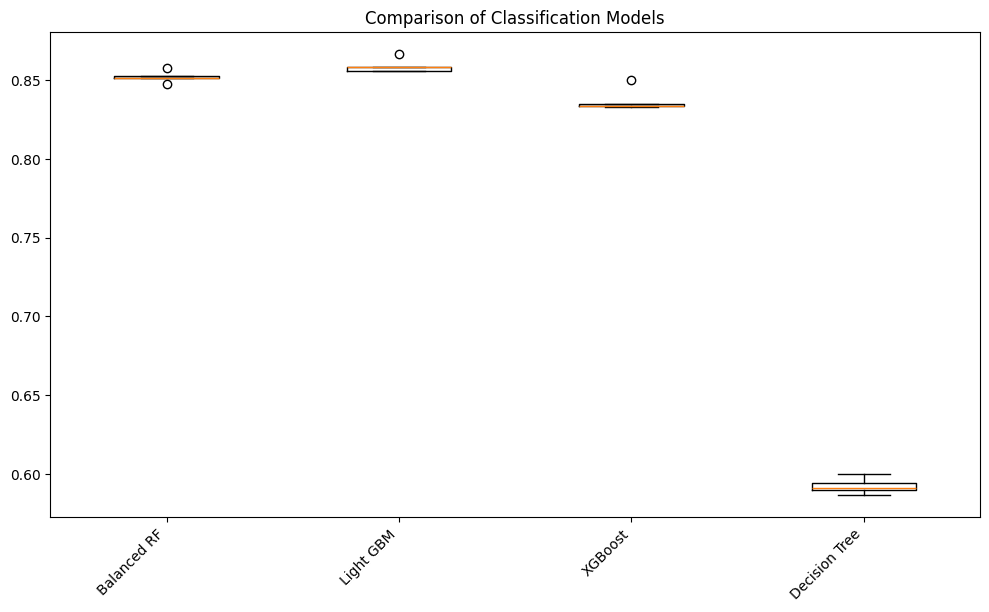

In [50]:
BRC = BalancedRandomForestClassifier(random_state=1234)
XGB = XGBClassifier(scale_pos_weight=19, random_state=1234)
LGB = LGBMClassifier(class_weight='balanced', random_state=1234)
DTC = DecisionTreeClassifier(class_weight='balanced', random_state=1234)

models = [BRC, LGB, XGB, DTC]

# Usando nomes mais curtos para facilitar
model_names = ["Balanced RF", "Light GBM", "XGBoost", "Decision Tree"]

results = []

# Treinando modelos
for item in models:
    pipe = pipeline(item)
    kfold = KFold(n_splits=5, random_state=42, shuffle=True)
    cv_results = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    msg = "%s: %f (%f)" % (model_names[models.index(item)], cv_results.mean(), cv_results.std())
    print(msg)

# Plotando a comparação dos modelos
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(results)
ax.set_xticklabels(model_names)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.title('Comparison of Classification Models')
plt.show()

É perceptível a diferença do Decision Tree para os outros modelos, sendo que os outros 3 tiveram resultados muito melhores. Apesar do Light GBM e do Balanced RF terem resultados muito próximos, seguirei com o Light GBM para esse projeto, principalmente porque ele é uma escolha sólida para detecção de fraudes em transações financeiras devido à sua eficiência, capacidade de lidar com dados desequilibrados, alta performance e flexibilidade.

# Ajuste dos hiperparâmetros

In [51]:
mlflow.end_run()

In [52]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment(experiment_name="Pipeline")
mlflow.start_run(run_name="Light GBM")

LGB = LGBMClassifier(class_weight='balanced', random_state=1234)
pipe = pipeline(LGB)

parameters = {
    'classifier__num_leaves': [31, 50, 100, 150],
    'classifier__max_depth': [10, 20, 30, 40, -1],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__n_estimators': [80, 100, 150, 200],
    'classifier__min_child_samples': [5, 10, 20, 50],
    'classifier__min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__reg_alpha': [0, 1e-1, 1, 2],
    'classifier__reg_lambda': [0, 1e-1, 1, 5],
    'classifier__boosting_type': ['gbdt', 'dart', 'goss']
}

random_search = RandomizedSearchCV(pipe, parameters, cv=4, n_jobs=4, scoring="roc_auc")
random_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % random_search.best_score_)
print(random_search.best_params_)
mlflow.log_metric("training_roc_auc", random_search.best_score_)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 5963, number of negative: 114037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2180
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 25
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from sc

# Avaliando o Modelo com os Dados de Teste

Após treinar alguns modelos e chegar na escolha final, está na hora de usar ele nos dados de teste, que ficaram intactos até o momento.

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


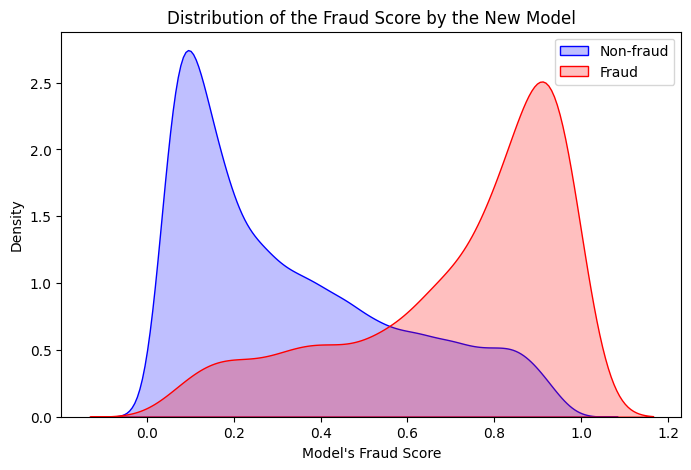

In [83]:
model = random_search.best_estimator_

y_test_pred = model.predict(X_test)
probs_test = model.predict_proba(X_test)

dataframe = df_test.copy()
dataframe['target_col'] = dataframe['fraude'] 
dataframe['prediction_col'] = probs_test[:,1]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.kdeplot(data=dataframe[dataframe['target_col'] == 0], x='prediction_col', ax=ax, color="b", fill=True)
sns.kdeplot(data=dataframe[dataframe['target_col'] == 1], x='prediction_col', ax=ax, color="r", fill=True)

plt.title("Distribution of the Fraud Score by the New Model")
plt.xlabel("Model's Fraud Score")
plt.ylabel("Density")
plt.legend(labels=['Non-fraud', 'Fraud'])
plt.show()

A principal diferença com o gráfico do modelo anterior, é que a densidade de "não fraudes" aumentou bastante no novo modelo.

O melhor threshold é: 66
O lucro máximo é: USD 70636.78


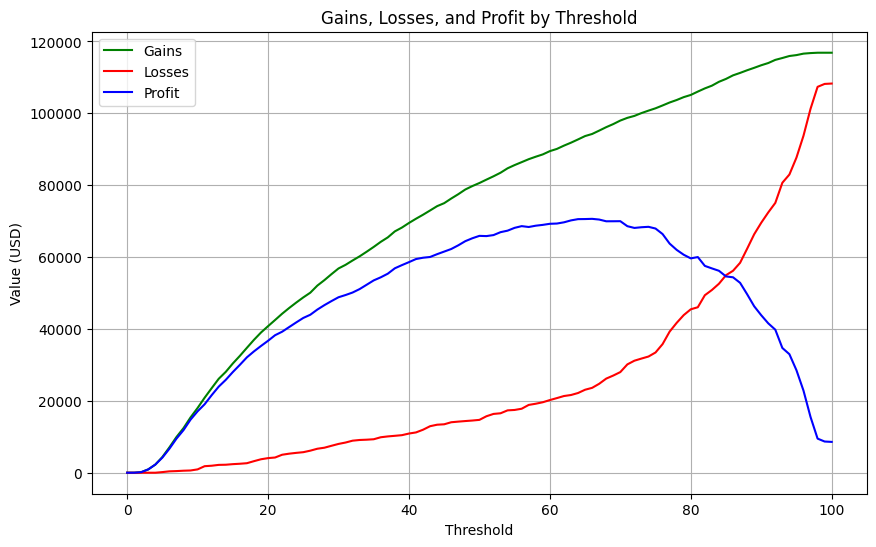

In [84]:
# Adicionando as previsões do novo modelo ao df_test com base nas probabilidades do novo modelo
df_test['new_predicted_fraud'] = probs_test[:, 1] * 100

# Inicializando listas para armazenar os resultados
thresholds = np.arange(0, 101)
gains_list = []
losses_list = []
profit_list = []

# Calculando ganhos, perdas e lucro para cada threshold
for threshold in thresholds:
    df_test['binary_predicted_fraud'] = df_test['new_predicted_fraud'] >= threshold
    
    gains = df_test[(df_test['fraude'] == 0) & (df_test['binary_predicted_fraud'] == False)]['valor_compra'].sum() * 0.1
    losses = df_test[(df_test['fraude'] == 1) & (df_test['binary_predicted_fraud'] == False)]['valor_compra'].sum()
    profit = gains - losses
    
    gains_list.append(gains)
    losses_list.append(losses)
    profit_list.append(profit)

# Convertendo listas para um dataframe para facilitar a análise
results_df = pd.DataFrame({
    'Threshold': thresholds,
    'Ganhos': gains_list,
    'Perdas': losses_list,
    'Lucro': profit_list
})

# Encontrando o threshold que maximiza o lucro
best_threshold = results_df.loc[results_df['Lucro'].idxmax(), 'Threshold']
max_profit = results_df['Lucro'].max()

print(f'O melhor threshold é: {best_threshold}')
print(f'O lucro máximo é: USD {max_profit:.2f}')

plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Ganhos'], label='Gains', color='green')
plt.plot(results_df['Threshold'], results_df['Perdas'], label='Losses', color='red')
plt.plot(results_df['Threshold'], results_df['Lucro'], label='Profit', color='blue')
plt.xlabel('Threshold')
plt.ylabel('Value (USD)')
plt.title('Gains, Losses, and Profit by Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
results_df[results_df['Threshold'] == 58]

,Threshold,Ganhos,Perdas,Lucro
58,58,87928.089,19197.48,68730.609


In [56]:
best_profit_ratio = 68221.308 / 87466.838
print(f'Razão de lucro: {best_profit_ratio}')

Razão de lucro: 0.779967694727915


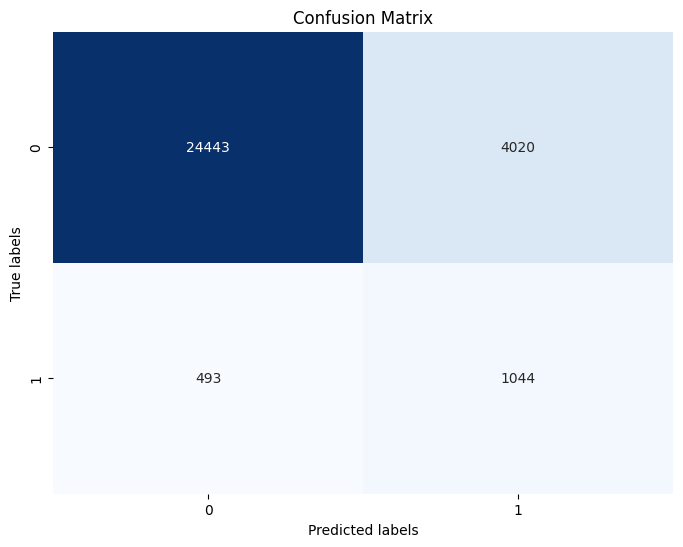

In [57]:
df_test['new_predicted'] = df_test['new_predicted_fraud'] >= best_threshold
cm = confusion_matrix(df_test['fraude'], df_test['new_predicted'])

def plot_confusion_matrix(cm):
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()
  
plot_confusion_matrix(cm)

In [58]:
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

new_fraud_rate = round(FN / (FN + TN), 2)
new_approval_rate = round((FN + TN) / (TN + FP + TP + FN), 2)

print(f'Taxa de fraude = {new_fraud_rate}')
print(f'Taxa de aprovação = {new_approval_rate}')

Taxa de fraude = 0.02
Taxa de aprovação = 0.83


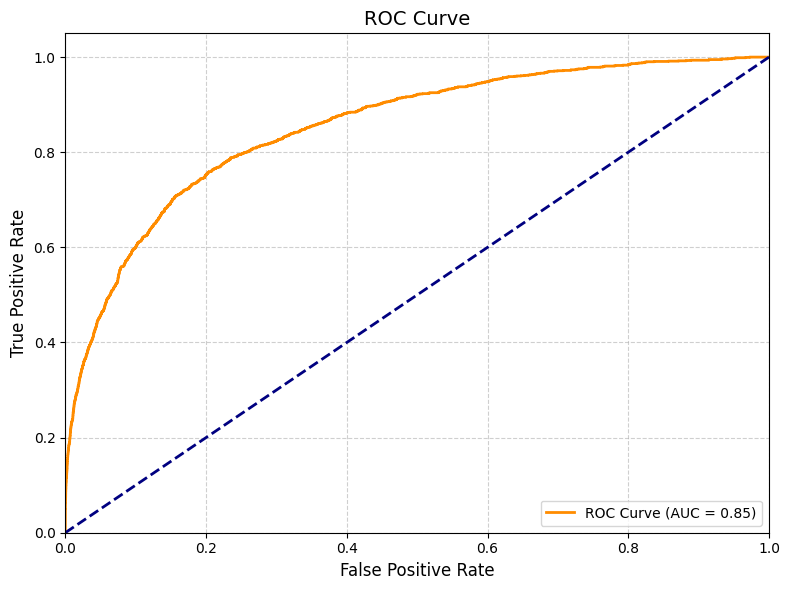

In [85]:
# Calculando as taxas de verdadeiros positivos e falsos positivos
fpr, tpr, thresholds = roc_curve(df_test['fraude'], df_test['new_predicted_fraud'])

# Calculando a AUC
auc = roc_auc_score(df_test['fraude'], df_test['new_predicted_fraud'])

# Plotando a Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14)
plt.legend(loc='lower right')
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [60]:
# Convertendo as probabilidades em classificações binárias com base no melhor threshold encontrado anteriormente
y_pred_binary = df_test['new_predicted_fraud'] >= best_threshold

# Calcula as métricas de desempenho
loss = log_loss(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Imprime as métricas de desempenho
print(f'Log Loss: {loss:.4f}')
print(f'Precisão: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

Log Loss: 5.4222
Precisão: 0.21
Recall: 0.68
F1-score: 0.32


Com as métricas e gráficos do novo modelo, podemos verificar diversas melhoras (que serão detalhadas no final do projeto):
- Com a mudança do threshold, o lucro e a razão de lucro aumentaram;
- Apesar da taxa de fraude ter permancecido a mesma, a taxa de aprovação aumentou;
- A AUC aumentou bastante, assim como as métricas gerais melhoraram também.

In [61]:
# Registrando as melhores métricas e encerrando a run do MLFlow
mlflow.log_metrics({
    "best_profit": max_profit,
    "best_threshold": best_threshold,
    "Log Loss": loss,
    "ROC-AUC": auc,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "Taxa de fraude": fraud_rate,
    "Taxa de aprovação": approval_rate,
    "Razão de lucro": best_profit_ratio
})

mlflow.end_run()

🏃 View run Light GBM at: http://127.0.0.1:5000/#/experiments/1/runs/2d6fdd198ca244d2a3d52991e0658e35
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


# SHAP

Falando um pouco sobre o SHAP... ele é utilizado para explicar e interpretar modelos de Machine Learning, fornecendo insights sobre como cada variável contribui para a predição de um modelo. Ele ajuda a entender o impacto das características nas decisões do modelo, promovendo transparência e confiança, além de ser fundamental em áreas sensíveis, como detecção de fraudes, onde é necessário justificar as predições feitas.

In [62]:
import shap
shap.initjs()

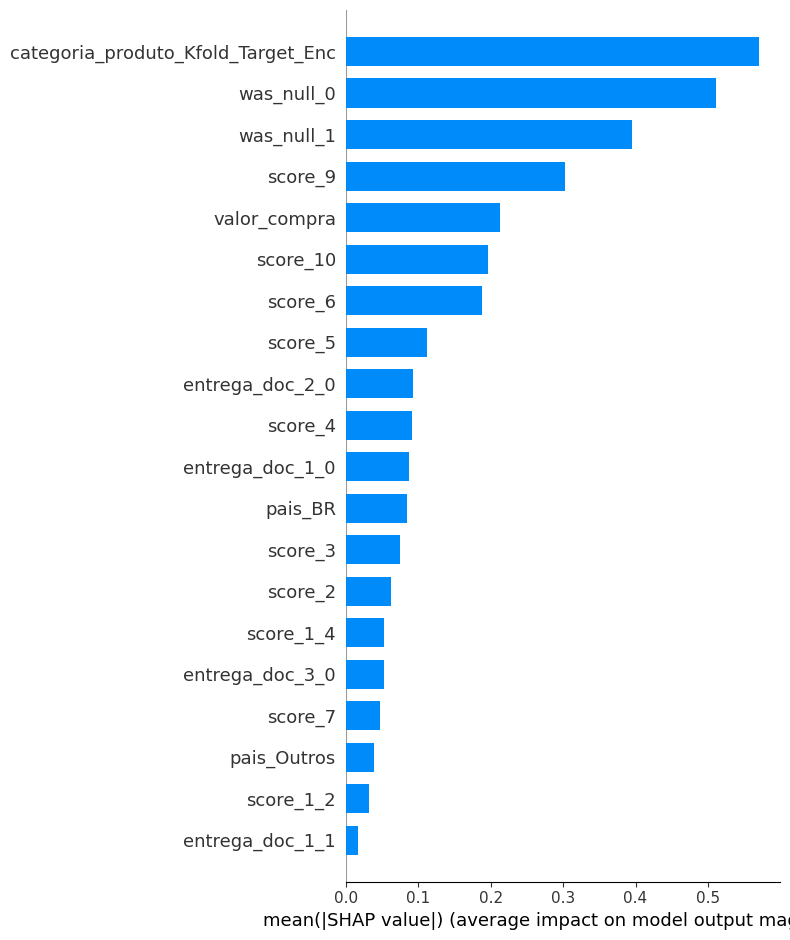

In [63]:
# Obtendo o pipeline de pré-processamento (sem o modelo final)
preprocessing_pipeline = Pipeline(model.steps[:-1])

# Transformando os dados de teste
X_test_transformed = preprocessing_pipeline.transform(X_test)

# Extraindo o modelo final (último passo do pipeline)
actual_model = model.steps[-1][1]

# Inicializando o explainer SHAP para o modelo final
explainer = shap.Explainer(actual_model)

# Calculando os valores SHAP
shap_values = explainer(X_test_transformed)

# Gráfico de importância das características para o modelo
shap.summary_plot(shap_values, X_test_transformed, plot_type="bar", title="Importância das Características")

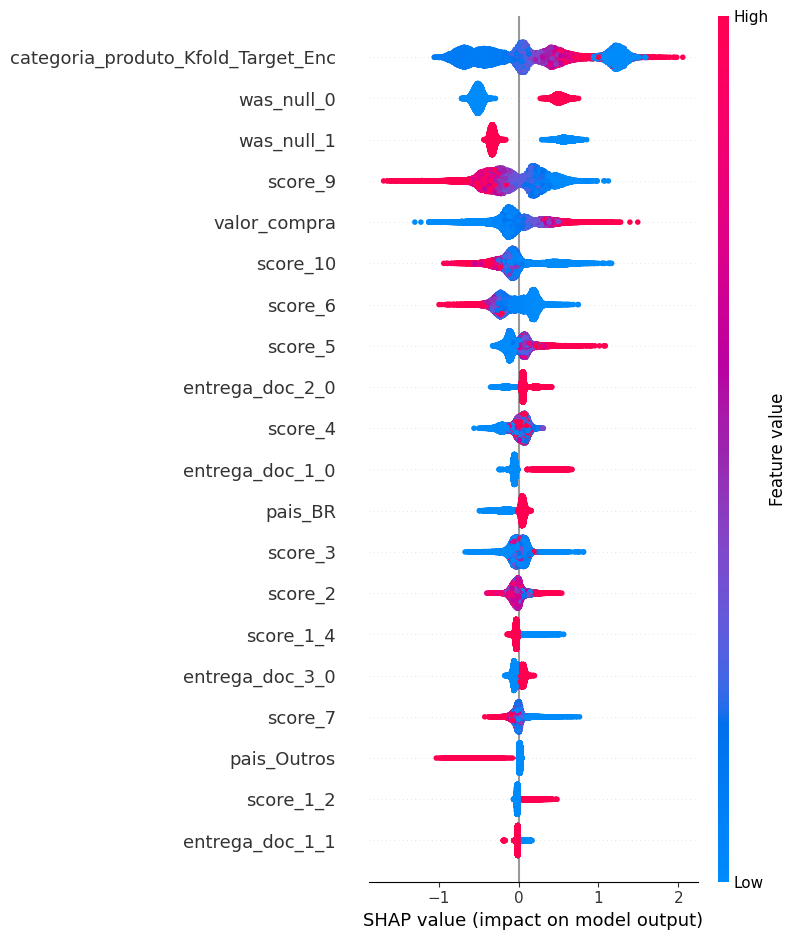

In [64]:
# Gráfico de dispersão dos valores SHAP para cada classe (fraude e não fraude)
shap.summary_plot(shap_values, X_test_transformed, title="Distribuição dos Valores SHAP")

Nos gráficos SHAP apresentados, temos duas visualizações típicas para análise de impacto das variáveis no modelo:

1. Gráfico de barras (mean |SHAP value|):

Este gráfico mostra o impacto médio de cada característica no modelo. O eixo vertical lista as variáveis, e o eixo horizontal mostra o valor médio do impacto absoluto de cada variável sobre a predição.

As variáveis mais impactantes no modelo, de acordo com o gráfico, são:
- `was_null_0`, que indica a entrega do doc 2 (determina que o registro não estava nulo nesse caso), e `categoria_produto_Kfold_Target_Enc`, que é uma codificação da categoria do produto, que mostrou ser um fator muito importante para a tomada de decisão sobre ser ou não fraude;
- `score_9`, `score_6`, e `score_10` também são muito importantes;
- Outras variáveis como `valor_compra` e `entrega_doc_2_0` também se destacam.

2. Gráfico de dispersão (SHAP value vs Feature value):

Esse gráfico mostra a distribuição dos valores SHAP de cada variável, juntamente com a cor associada aos valores da própria característica (quanto mais vermelha a cor, maior o valor da característica).

Variáveis como `was_null_0` e `categoria_produto_Kfold_Target_Enc` continuam mostrando um grande impacto no modelo. A dispersão ao redor do valor zero indica que estas variáveis têm um efeito tanto para predições de fraude quanto de não fraude.

O comportamento de `score_9`, `score_6` e outras variáveis também é interessante: variáveis com uma grande quantidade de dispersão ao redor de zero sugerem que possuem um efeito balanceado no modelo, enquanto variáveis como `entrega_doc_2_0` mostram mais concentração em uma direção, sugerindo um impacto mais direto.

# Cálculos Financeiros (Diferenças Entre os Modelos)

In [65]:
# Convertendo a coluna 'data_compra' para o tipo datetime
df['data_compra'] = pd.to_datetime(df['data_compra'])

# Calculando a média de compras por mês
df['mes_ano'] = df['data_compra'].dt.to_period('M')  # Extraindo mês e ano
media_compras_por_mes = df.groupby('mes_ano').size().mean()

# Calculando o valor médio das compras no total
media_valor_compras = df['valor_compra'].mean()

# Exibindo os resultados
print(f'Média de compras por mês: {media_compras_por_mes}')
print(f'Valor médio das compras: {media_valor_compras:.2f}')

Média de compras por mês: 75000.0
Valor médio das compras: 43.52


Conhecendo a média de compras por mês e o valor médio dessas compras (calculando pelo total de registros no dataset), podemos fazer alguns cálculos para chegar no valor de lucro que o nosso modelo consegue gerar para a empresa.

In [66]:
# Calculando o total transacionado por mês baseado nas médias calculadas
total_mensal = media_compras_por_mes * media_valor_compras

# Calculando o total de ganhos que a instituição poderia ter caso tivesse 100% de acerto nas predições (10% do total mensal)
ganho_total_mensal = 0.1 * total_mensal

# Calculando o lucro real pela razão de lucro do modelo antigo
lucro_modelo_antigo = 0.68 * ganho_total_mensal
# Calculando o lucro real pela razão de lucro do modelo novo
lucro_modelo_novo = 0.78 * ganho_total_mensal

# Exibindo os resultados
print(f'Valor transacionado por mês (baseado nas médias): {total_mensal:.2f}')
print(f'Possível total de ganhos por mês (caso acertasse 100%): {ganho_total_mensal:.2f}')
print(f'Lucro mensal obtido pelo modelo antigo: {lucro_modelo_antigo:.2f}')
print(f'Lucro mensal obtido pelo modelo novo: {lucro_modelo_novo:.2f}')

Valor transacionado por mês (baseado nas médias): 3264235.06
Possível total de ganhos por mês (caso acertasse 100%): 326423.51
Lucro mensal obtido pelo modelo antigo: 221967.98
Lucro mensal obtido pelo modelo novo: 254610.33


# Conclusões Finais

Passando por todo o projeto, podemos resumir os resultados em 4 principais pontos, comparando o modelo baseline com o novo modelo treinado:

1. Métricas financeiras (considerando dados de teste)
- Threshold: passou de 73 para 64
- Ganhos: passou de $80330 para $88201
- Perdas: passou de $25353 para $22471
- Lucro: passou de $54977 para $65730

2. Matriz de confusão e taxas de fraude e aprovação (considerando dados de teste)
- Falsos negativos: passou de 503 para 479 (diminuir esse quadrante da matriz é especialmente importante, pois é aquele que causa prejuízo dobrado para a instituição, perdendo a comissão de 10% e ainda tendo que pagar 100% do valor para o cliente)
- Taxa de fraude permaneceu a mesma (2%), enquanto a de aprovação passou de 74% para 82%

3. Métricas de desempenho
- Log Loss: passou de 8.6 para 5.8 (diminuir essa métrica indica que o modelo está fazendo previsões melhores)
- Precisão: passou de 0.13 para 0.19 (indica que o novo modelo conseguiu classificar mais fraudes que realmente eram fraudes)
- Recall: passou de 0.67 para 0.69 (indica que o novo modelo conseguiu identificar melhor as fraudes que realmente eram fraudes)
- F1-score: passou de 0.22 para 0.30 (como o F1-score é a média harmônica da precisão e do recall, tendo aumentado ambos, essa métrica também cresceu)
- ROC-AUC: passou de 0.73 para 0.85 (o novo modelo está conseguindo generalizar melhor, entendendo as diferenças entre fraudes e não fraudes)

4. O que realmente importa no fim do dia... qual o lucro a mais que foi gerado?
- Como calculado acima, considerando as médias de compras por mês, e a média dos valores das compras, o modelo inicial, por ter uma razão de lucro de 68%, conseguiria um lucro mensal de aproximadamente $221968. Enquanto o modelo novo, com uma razão de lucro de 78%, conseguiria um lucro mensal de aproximadamente $254610
- Por mês, isso representa uma diferença de $32642, e por ano de $391704 a mais que a instituição irá ganhar de lucro. Isso representa um aumento de lucros anuais em 15%.

Ou seja, o novo modelo treinado não só melhora a capacidade de detecção de compras fraudulentas, como também aumenta consideravelmente os lucros da empresa.